# Use updated parameters and analysis to calculate the flux of a torsion

In [1]:
from __future__ import division, print_function

import datetime
import decimal
import glob
import inspect
import os as os
import sys

import math as math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import scipy as sc
from math import pi
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import genfromtxt
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
from scipy import stats


%load_ext autoreload
%autoreload 2
%matplotlib inline

import seaborn as sns
sns.set(style='ticks', palette='Set2')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
class simulation(object):
    def plot_energy(self):
        """
        This function plots the unbound and bound energies associated with a simulation object.
        """
        fig = plt.figure(figsize=(12, 12))
        gs = GridSpec(2, 2, wspace=0.2, hspace=0.5)
        ax1 = plt.subplot(gs[0, 0])
        ax2 = plt.subplot(gs[0, 1])
        ax1.plot(range(self.bins), self.unbound, c='r')
        ax1.set_title('Unbound chemical-potential-like energies', y=1.05)
        ax2.plot(range(self.bins), self.bound, c='b')
        ax2.set_title('Bound chemical-potential-like energies', y=1.05)
        plt.show()

    def plot_ss(self):
        """
        This function plots the steady-state distribution and Boltzmann PDF associated with a simulation object. 
        By default, this will plot the eigenvector-derived steady-state distribution.
        """
        boltzmann_unbound = np.exp(-self.unbound / self.kT)
        boltzmann_bound = np.exp(-self.bound / self.kT)
        self.PDF_unbound = boltzmann_unbound / np.sum((boltzmann_unbound))
        self.PDF_bound = boltzmann_bound / np.sum((boltzmann_bound))

        fig = plt.figure(figsize=(12, 12))
        gs = GridSpec(2, 2, wspace=0.2, hspace=0.5)
        ax1 = plt.subplot(gs[0, 0])
        ax2 = plt.subplot(gs[0, 1])
        ax1.plot(range(self.bins), self.ss[0:self.bins], c='r', label='SS')
        ax1.plot(range(self.bins), self.PDF_unbound, c='k', label='PDF')
        ax1.legend()
        ax1.set_title('Unbound steady-state', y=1.05)

        ax2.plot(range(self.bins), self.ss[self.bins:2 * self.bins], c='b', label='SS')
        ax2.plot(range(self.bins), self.PDF_bound, c='k', label='PDF')
        ax2.set_title('Bound steady-state', y=1.05)
        ax2.legend()
        plt.show()

    def plot_flux(self, label=None):
        """
        This function plots the intrasurface flux sum and labels the graph with the attributions of the 
        simulation object.
        """
        fig = plt.figure(figsize=(12, 12))
        gs = GridSpec(2, 1, wspace=0.2, hspace=0.5)
        ax1 = plt.subplot(gs[0, 0])
        ax1.plot(range(self.bins), self.flux_u, c='r', label='U')
        ax1.plot(range(self.bins), self.flux_b, c='b', label='B')
        ax1.plot(range(self.bins), self.flux_b + self.flux_u, c='k', label='U+B')
        ax1.legend()
        if label is not None:
            ax1.set_title('{}: C_u = {:6.2e}, C_ub = {}, catalysis = {}, cATP = {}, dt = {}'.format(label, self.C_intrasurface,
                                                                                           self.C_intersurface,
                                                                                           self.catalytic_rate,
                                                                                           self.cATP, self.dt), y=1.05)
        else:
            ax1.set_title(
                'Intra = {:6.2e}, Inter = {}, catalytic rate = {}, cATP = {}'.format(self.C_intrasurface, self.C_intersurface,
                                                                             self.catalytic_rate, self.cATP), y=1.05)
        plt.show()
        
        
    def data_to_energy(self, histogram):
        """    
        This function takes in population histograms from Chris' PKA data and
        (a) smoothes them with a Gaussian kernel with width 1;
        (b) eliminates zeros by setting any zero value to the minimum of the data;
        (c) turns the pouplation histograms to energy surfaces.
        """

        histogram_smooth = gaussian_filter(histogram, 1)
        histogram_copy = np.copy(histogram_smooth)
        for i in range(self.bins):
            if histogram_smooth[i] != 0:
                histogram_copy[i] = histogram_smooth[i]
            else:
                histogram_copy[i] = min(histogram_smooth[np.nonzero(histogram_smooth)])
        histogram_smooth = histogram_copy
        assert(not np.any(histogram_smooth == 0))
        energy = -self.kT * np.log(histogram_smooth)
        return energy


    def calculate_intrasurface_rates(self, energy_surface):
        """
        This function calculates intrasurface rates using the energy difference between adjacent bins.
        """
        forward_rates = self.C_intrasurface * np.exp(-1 * np.diff(energy_surface) / float(2 * self.kT))
        backward_rates = self.C_intrasurface * np.exp(+1 * np.diff(energy_surface) / float(2 * self.kT))
        rate_matrix = np.zeros((self.bins, self.bins))
        for i in range(self.bins - 1):
            rate_matrix[i][i + 1] = forward_rates[i]
            rate_matrix[i + 1][i] = backward_rates[i]
        rate_matrix[0][self.bins - 1] = self.C_intrasurface * np.exp(
            -(energy_surface[self.bins - 1] - energy_surface[0]) / float(2 * self.kT))
        rate_matrix[self.bins - 1][0] = self.C_intrasurface * np.exp(
            +(energy_surface[self.bins - 1] - energy_surface[0]) / float(2 * self.kT))
        return rate_matrix

    def calculate_intersurface_rates(self, unbound_surface, bound_surface):
        """
        This function calculates the intersurface rates in two ways.
        For bound to unbound, the rates are calculated according to the energy difference and the catalytic rate.
        For unbound to bound, the rates depend on the prefactor and the concentration of ATP.
        """
        bu_rm = np.empty((self.bins))
        ub_rm = np.empty((self.bins))
        for i in range(self.bins):
            bu_rm[i] = (self.C_intersurface *
                        np.exp(-1 * (unbound_surface[i] - bound_surface[i]) / float(self.kT)) +
                        self.catalytic_rate)
            ub_rm[i] = self.C_intersurface * self.cATP
        return ub_rm, bu_rm

    def compose_tm(self, u_rm, b_rm, ub_rm, bu_rm):
        """
        We take the four rate matrices (two single surface and two intersurface) and inject them into the transition matrix.
        """
        tm = np.zeros((2 * self.bins, 2 * self.bins))
        tm[0:self.bins, 0:self.bins] = u_rm
        tm[self.bins:2 * self.bins, self.bins:2 * self.bins] = b_rm
        for i in range(self.bins):
            tm[i, i + self.bins] = ub_rm[i]
            tm[i + self.bins, i] = bu_rm[i]
        self.tm = self.scale_tm(tm)
        return

    def scale_tm(self, tm):
        """
        The transition matrix is scaled by `dt` so all rows sum to 1 and all elements are less than 1.
        This should not use `self` subobjects, except for `dt` because we are mutating the variables.
        """
        row_sums = tm.sum(axis=1, keepdims=True)
        maximum_row_sum = int(math.log10(max(row_sums)))
        self.dt = 10 ** -(maximum_row_sum + 1)
        tm_scaled = self.dt * tm
        row_sums = tm_scaled.sum(axis=1, keepdims=True)
        if np.any(row_sums > 1):
            print('Row sums unexpectedly greater than 1.')
        for i in range(2 * self.bins):
            tm_scaled[i][i] = 1.0 - row_sums[i]
        return tm_scaled

    def calculate_eigenvector(self):
        """
        The eigenvectors and eigenvalues of the transition matrix are computed and the steady-state population is
        assigned to the eigenvector with an eigenvalue of 1.
        """
        eigenvalues, eigenvectors = np.linalg.eig(np.transpose(self.tm))
        ss = abs(eigenvectors[:, eigenvalues.argmax()].astype(float))
        # print('Maximum eigenvalue = {}'.format(eigenvalues[eigenvalues.argmax()]))
        self.ss = ss / np.sum(ss)
        return

    def calculate_flux(self, ss, tm):
        """
        This function calculates the intrasurface flux using the steady-state distribution and the transition matrix.
        The steady-state distribution is a parameter so this function can be run with either the eigenvector-derived
        steady-state distribution or the interated steady-state distribution.
        """
        flux_u = np.empty((self.bins))
        flux_b = np.empty((self.bins))
        for i in range(self.bins):
            if i == 0:
                flux_u[i] = - ss[i] * tm[i][i + 1] / self.dt + ss[i + 1] * tm[i + 1][i] / self.dt
            if i == self.bins - 1:
                flux_u[i] = - ss[i] * tm[i][0] / self.dt + ss[0] * tm[0][i] / self.dt
            else:
                flux_u[i] = - ss[i] * tm[i][i + 1] / self.dt + ss[i + 1] * tm[i + 1][i] / self.dt
        for i in range(self.bins, 2 * self.bins):
            if i == self.bins:
                flux_b[i - self.bins] = - ss[i] * tm[i][i + 1] / self.dt + ss[i + 1] * tm[i + 1][i] / self.dt
            if i == 2 * self.bins - 1:
                flux_b[i - self.bins] = - ss[i] * tm[i][self.bins] / self.dt + ss[self.bins] * tm[self.bins][i] / self.dt
            else:
                flux_b[i - self.bins] = - ss[i] * tm[i][i + 1] / self.dt + ss[i + 1] * tm[i + 1][i] / self.dt
        self.flux_u = flux_u
        self.flux_b = flux_b
        return

    def iterate(self, iterations=None):
        """
        A template population distribution is multiplied by the transition matrix. 
        By default, iterations are 0. The output of this command is set to
        `self.iterative_ss` which can be passed to `calculate_flux`. 
        The new population can be set to a normalized random distribution or the eigenvector-derived 
        steady-state distribution.
        """
        print('Running iterative method with {} iterations'.format(self.iterations))
        population = np.random.rand(2 * self.bins)
        row_sums = population.sum(axis=0, keepdims=True)
        population = population / row_sums
        iterations = 0
        if self.ss is not None:
            new_population = self.ss
        for i in range(self.iterations):
            new_population = np.dot(new_population, self.tm)
        self.iterative_ss = new_population
        return
    
    def JSD(self):
        """
        Calculate the Jensen-Shannon divergence between the two surfaces.
        Using energy instead of probability right now.
        """
        from scipy.stats import entropy
        from numpy.linalg import norm
        _P = self.unbound / norm(self.unbound, ord=1)
        _Q = self.bound / norm(self.bound, ord=1)
        _M = 0.5 * (_P + _Q)
        return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))
    
    def JSD_2(self): #Jensen-shannon divergence
        x = np.array(self.unbound)
        y = np.array(self.bound)
        d1 = x*np.log2(2*x/(x+y))
        d2 = y*np.log2(2*y/(x+y))
        d1[np.isnan(d1)] = 0
        d2[np.isnan(d2)] = 0
        d = 0.5*np.sum(d1+d2)    
        return d
    
    def JSD_3(self, x, y): #Jensen-shannon divergence
        x = np.array(x)
        y = np.array(y)
        d1 = x*np.log2(2*x/(x+y))
        d2 = y*np.log2(2*y/(x+y))
        d1[np.isnan(d1)] = 0
        d2[np.isnan(d2)] = 0
        d = 0.5*np.sum(d1+d2)    
        return d



    def simulate(self, plot=False):
        """
        This function runs the `simulation` which involves:
        (a) setting the unbound intrasurface rates,
        (b) setting the bound intrasurface rates,
        (c) setting the intersurface rates,
        (d) composing the transition matrix,
        (e) calculating the eigenvectors of the transition matrix,
        (f) calculating the intrasurface flux,
        and optionally (g) running an interative method to determine the steady-state distribution.
        """
        u_rm = self.calculate_intrasurface_rates(self.unbound)
        b_rm = self.calculate_intrasurface_rates(self.bound)
        ub_rm, bu_rm = self.calculate_intersurface_rates(self.unbound, self.bound)
        self.compose_tm(u_rm, b_rm, ub_rm, bu_rm)
        self.calculate_eigenvector()
        self.calculate_flux(self.ss, self.tm)
        if plot:
            self.plot_energy()
            self.plot_ss()
            self.plot_flux(label='Eigenvector method')
        # print('Eigenvector method: intrasurface flux sum = {}'.format(np.sum(self.flux_u+self.flux_b)))
        self.iterate(self.iterations)
        self.calculate_flux(self.iterative_ss, self.tm)
        if plot:
            self.plot_flux(label='Iterative method')
        # print('Iterative method: Intrasurface flux sum = {}'.format(np.sum(self.flux_u+self.flux_b)))
        return


    def __init__(self):
        """
        These values are assigned to a new object, unless overridden later.
        """
        self.kT = 0.6
        self.C_intersurface = 0.24
        # self.C_intrasurface = 2.28 * 10 ** 13
        self.C_intrasurface_0 = 1.37 * 10 ** 14 # degrees/second
        self.cATP = 30
        self.offset_factor = 6.25
        self.catalytic_rate = 140
        self.unbound = np.array([saw(i, 20) for i in range(20)])
        self.bound = np.array([saw(i + 10, 20) for i in range(20)])
        self.bins = len(self.unbound)
        self.tm = np.zeros((self.bins, self.bins))
        self.iterations=0
        self.C_intrasurface = self.C_intrasurface_0 / (360. / self.bins)



In [3]:
def saw(x, a):
    return 2 * (x / a - np.floor(1 / 2 + x / a))


def variable_saw(y, x, a):
    return y * (x / a - np.floor(1 / 2 + x / a))

# Run once with plotting turned on and default values

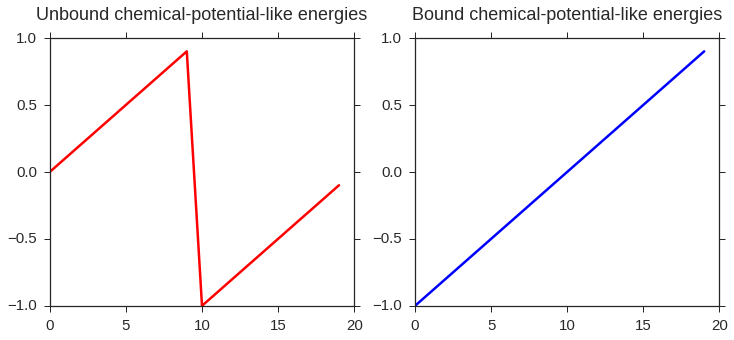

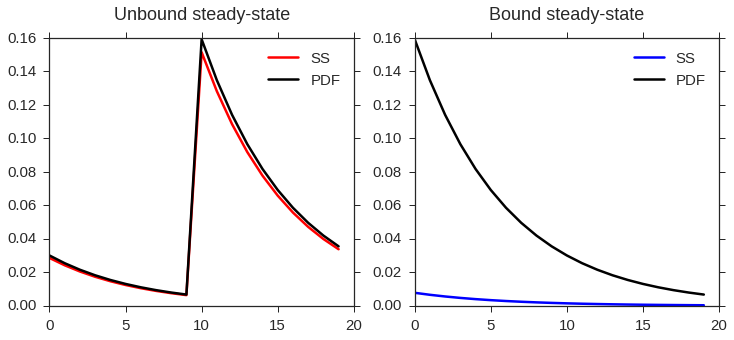

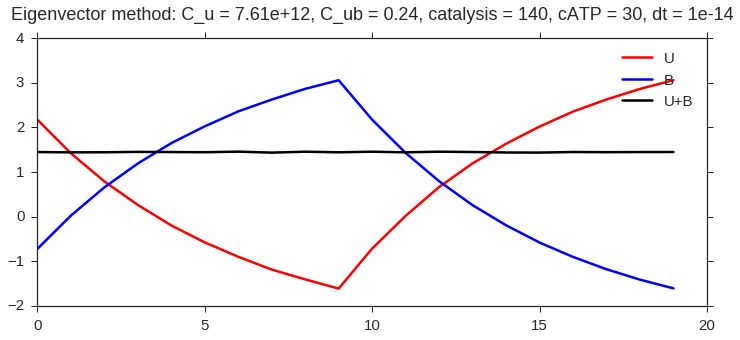

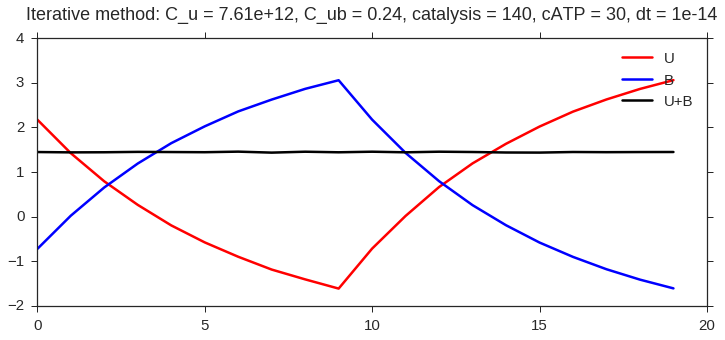

In [271]:
example = simulation()
example.simulate(plot=True)

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:152: ComplexWarning: Casting complex values to real discards the imaginary part


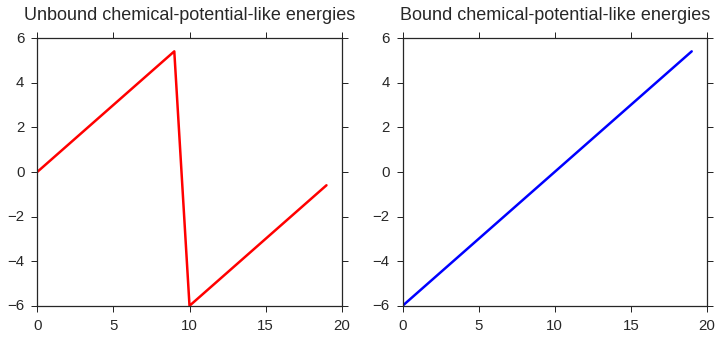

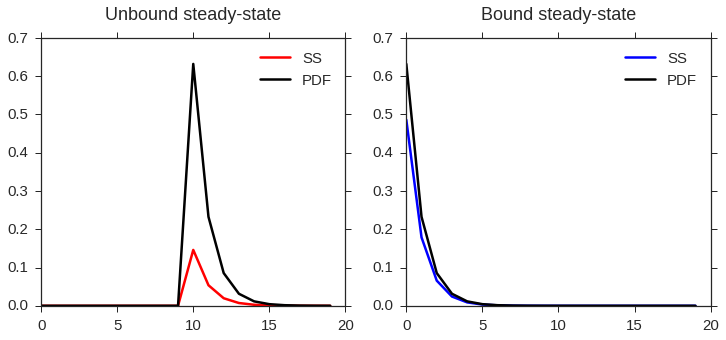

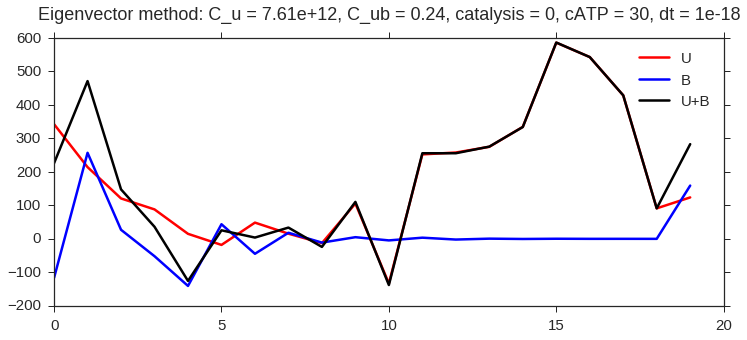

Running iterative method with 0 iterations


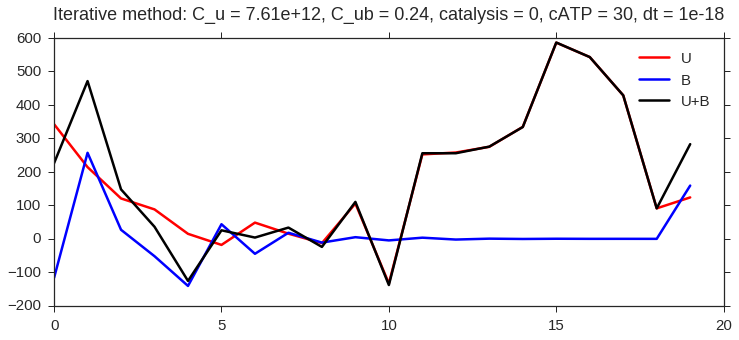

In [45]:
example = simulation()
example.catalytic_rate = 0
example.unbound = np.array([variable_saw(12, i, 20) for i in range(20)])
example.bound = np.array([variable_saw(12, i + 10, 20) for i in range(20)])
example.iterations = 0
example.simulate(plot=True)

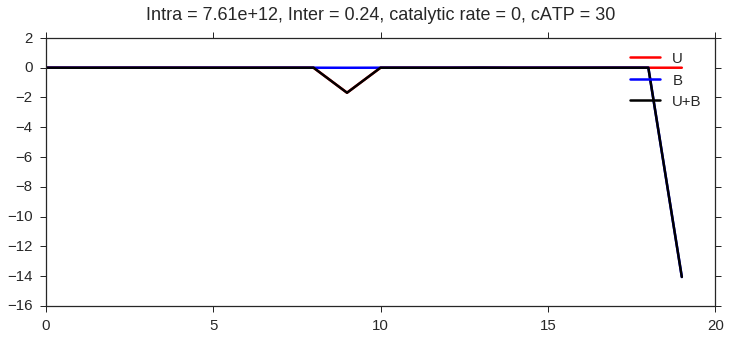

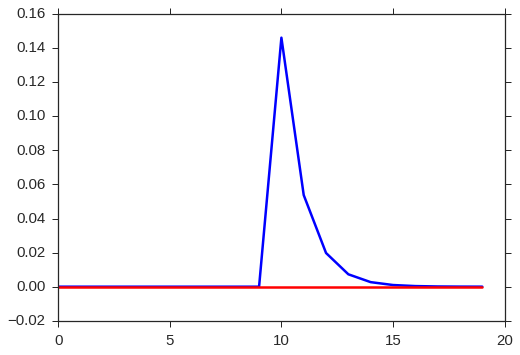

In [341]:
bicg_ss = bicg(example.tm-1, np.zeros((2*example.bins)), x0=example.ss, tol=1e-20)

example.calculate_flux(bicg_ss[0], example.tm)
example.plot_flux()

plt.figure()
plt.plot(range(example.bins), example.ss[0:example.bins], c='b')
plt.plot(range(example.bins), bicg_ss[0][0:example.bins], c='r')
plt.show()


In [410]:
from scipy.optimize import fmin_cobyla
from scipy.optimize import minimize
example = simulation()
example.catalytic_rate = 0
example.unbound = np.array([variable_saw(12, i, 20) for i in range(20)])
example.bound = np.array([variable_saw(12, i + 10, 20) for i in range(20)])
example.iterations = 0
example.simulate()

def objective(p, *args):
    return np.sum(np.dot(example.tm, p))**2 # !? is the sum correct?

def eq_constraint(p, *args):
    return 1 - np.sum(p)

def ineq_constraint(p, *args):
    """constrain all elements of x to be >= 0"""
    return p

# bnds = ((0, 1), (0, 1))
bnds = ([(0, 1)]*len(example.ss))

constraints = [{'type': 'ineq', 'fun': ineq_constraint},
               {'type': 'eq', 'fun': eq_constraint}]

# constraints = [{'type': 'eq', 'fun': eq_constraint}]


result = minimize(objective, example.ss, constraints=constraints, args=example.tm, tol=1e-20)

# cobyla_ss = fmin_cobyla(objective, example.ss, [constr1, ineq_constraint], args=example.tm)

Running iterative method with 0 iterations


/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:152: ComplexWarning: Casting complex values to real discards the imaginary part


In [411]:
result['x']

array([  5.34796917e-17,   2.69960610e-17,  -1.17362774e-16,
        -1.11659168e-16,  -9.64760284e-18,   6.13583269e-17,
        -1.27563327e-17,  -7.65414955e-17,   5.43032045e-18,
         4.99999960e-01,   6.85561936e-17,  -1.06790539e-16,
        -3.05640398e-17,  -9.56403831e-17,   9.39321203e-17,
         8.29654374e-17,   1.68620231e-17,   2.03358051e-17,
        -3.99673258e-17,  -6.17224107e-17,  -1.23587496e-17,
         2.45947545e-17,  -3.64716538e-17,  -7.78119324e-17,
        -5.08211313e-18,  -1.48938400e-17,   5.14454931e-17,
         2.71730219e-18,  -3.93384853e-17,   6.48642628e-18,
         2.94275686e-17,   1.87813980e-17,  -3.37173525e-17,
        -7.06282040e-18,   4.09063697e-17,   5.71699875e-17,
        -1.93312182e-17,  -3.43272569e-17,   3.54234308e-17,
         5.00000040e-01])

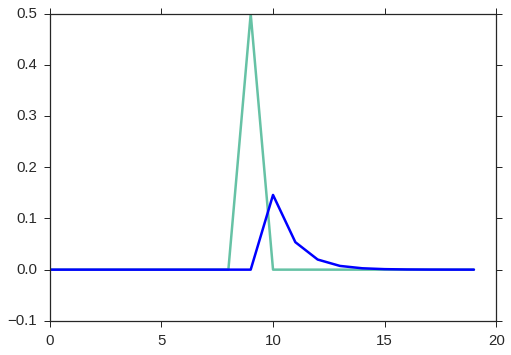

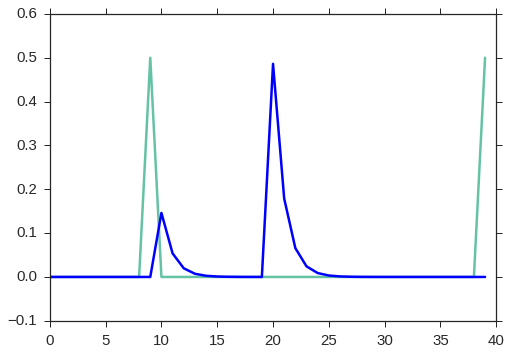

In [413]:
plt.figure()
plt.plot(range(example.bins), result['x'][0:example.bins])
plt.plot(range(example.bins), example.ss[0:example.bins], c='b')
plt.show()

plt.figure()
plt.plot(range(2*example.bins), result['x'])
plt.plot(range(2*example.bins), example.ss, c='b')
plt.show()



IS this really a solution?

In [403]:
diff = np.dot(example.tm, result['x']) - result['x']

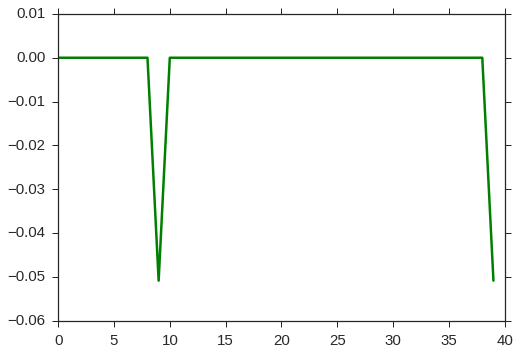

In [406]:
plt.figure()
plt.plot(range(2* example.bins), diff, c='g')
plt.show()

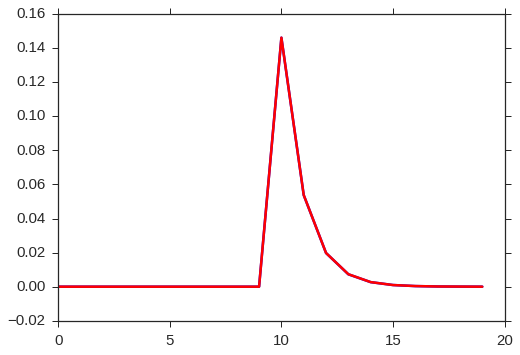

In [368]:
plt.figure()
plt.plot(range(example.bins), example.ss[0:example.bins], c='b')
plt.plot(range(example.bins), cobyla_ss[0:example.bins], c='r')
plt.show()


# Run a few times without plotting.

In [133]:
small_catalysis = simulation()
small_catalysis.catalysis = 1
small_catalysis.simulate(plot=False)

medium_catalysis = simulation()
medium_catalysis.catalysis = 100
medium_catalysis.simulate(plot=False)

large_catalysis = simulation()
large_catalysis.catalysis = 1000
large_catalysis.simulate(plot=False)

Maximum eigenvalue = 1.0000000000000009
Eigenvector method: intrasurface flux sum = 28.989389896392822
Iterative method: Intrasurface flux sum = 28.989389896392822
Maximum eigenvalue = 1.0000000000000009
Eigenvector method: intrasurface flux sum = 28.989389896392822
Iterative method: Intrasurface flux sum = 28.989389896392822
Maximum eigenvalue = 1.0000000000000009
Eigenvector method: intrasurface flux sum = 28.989389896392822
Iterative method: Intrasurface flux sum = 28.989389896392822


# Run the iterative method with 1,000,000 iterations

Maximum eigenvalue = 1.0000000000000009


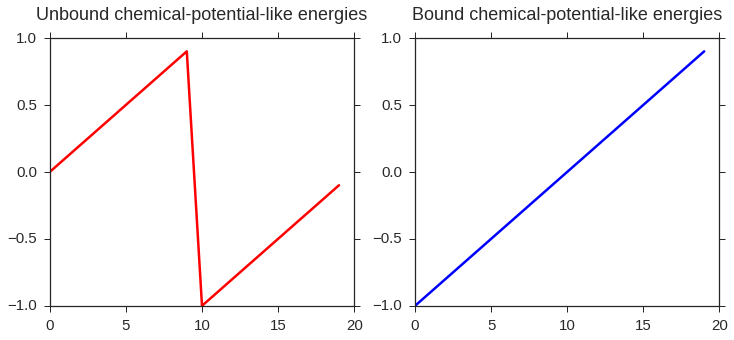

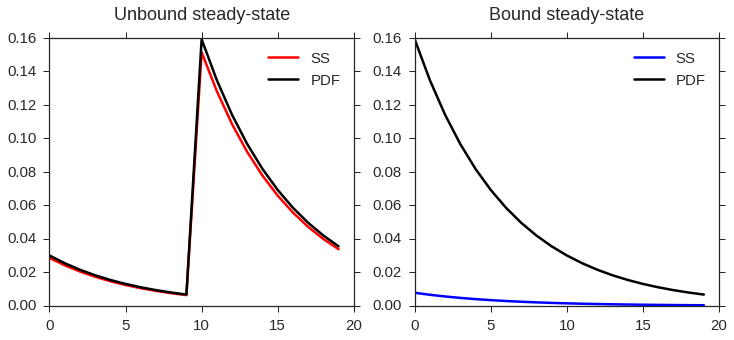

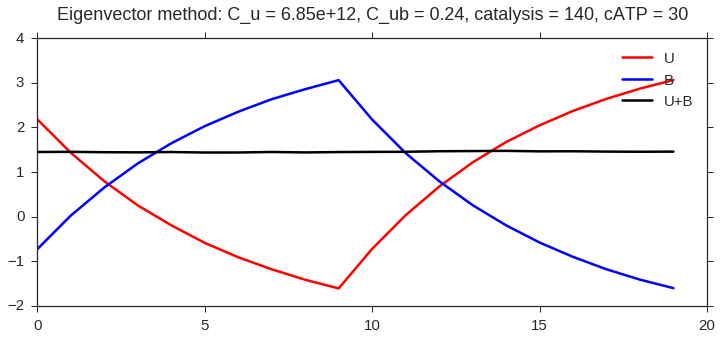

Eigenvector method: intrasurface flux sum = 28.989389896392822


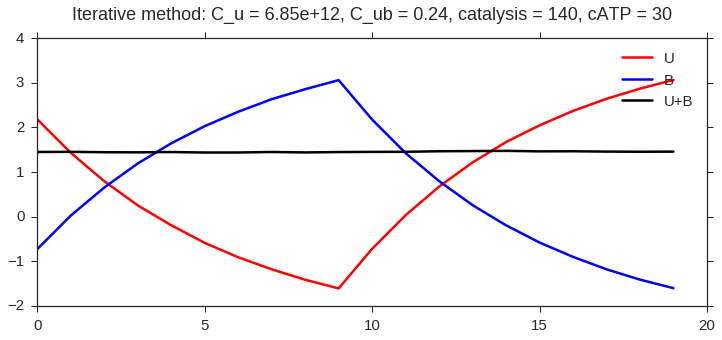

Iterative method: Intrasurface flux sum = 28.989389896392822


In [134]:
iterative = simulation()
iterative.iterations = 1000000
iterative.simulate(plot=True)

# Scan over the number of iterations for the iterative method

Maximum eigenvalue = 1.0000000000000002
Eigenvector method: intrasurface flux sum = 384.4413652420044
Iterative method: Intrasurface flux sum = 384.4413652420044
Maximum eigenvalue = 1.0000000000000002
Eigenvector method: intrasurface flux sum = 384.4413652420044
Iterative method: Intrasurface flux sum = 384.4413652420044
Maximum eigenvalue = 1.0000000000000002
Eigenvector method: intrasurface flux sum = 384.4413652420044
Iterative method: Intrasurface flux sum = 384.4413652420044
Maximum eigenvalue = 1.0000000000000002
Eigenvector method: intrasurface flux sum = 384.4413652420044
Iterative method: Intrasurface flux sum = 384.4413652420044
Maximum eigenvalue = 1.0000000000000002
Eigenvector method: intrasurface flux sum = 384.4413652420044
Iterative method: Intrasurface flux sum = 384.4413652420044
Maximum eigenvalue = 1.0000000000000002
Eigenvector method: intrasurface flux sum = 384.4413652420044
Iterative method: Intrasurface flux sum = 384.4413652420044
Maximum eigenvalue = 1.00000

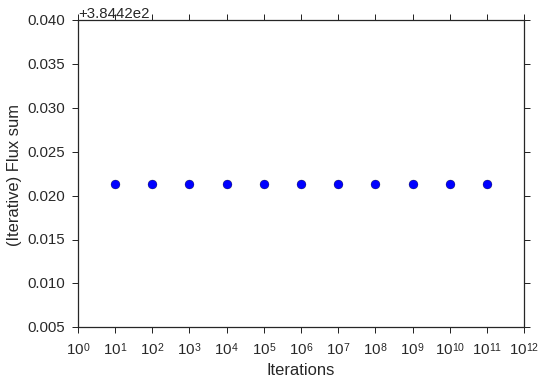

In [135]:
fig = plt.figure()
ax = plt.subplot(111)
clr = sns.color_palette("Blues", 13)

for j in np.arange(1, 12, 1):
    iterations = 10**j
    w = simulation()
    w.cATP = 10000 # Override the default amount of ATP
    w.unbound =  np.array([variable_saw(1.7, i, 20) for i in range(20)])  # Override the default sawtooth
    w.bound =  np.array([variable_saw(1.7, i+10, 20) for i in range(20)]) # Override the default sawtooth
    w.iterations = iterations # Override the default number of iterations
    w.simulate()
    
    plt.scatter(iterations, np.sum(w.flux_u+w.flux_b), s=80)
            
plt.ylabel('(Iterative) Flux sum')
plt.xlabel('Iterations')
plt.xscale('log')
plt.show()


# Scan over the concentration of ATP

Maximum eigenvalue = 1.0000000000000018
Eigenvector method: intrasurface flux sum = 0.7927545011043549
Iterative method: Intrasurface flux sum = 0.7927545011043549
Maximum eigenvalue = 0.999999999999999
Eigenvector method: intrasurface flux sum = 87.13417720794678
Iterative method: Intrasurface flux sum = 87.13417720794678
Maximum eigenvalue = 1.0
Eigenvector method: intrasurface flux sum = 151.2297878265381
Iterative method: Intrasurface flux sum = 151.2297878265381
Maximum eigenvalue = 1.0000000000000009
Eigenvector method: intrasurface flux sum = 200.99566459655762
Iterative method: Intrasurface flux sum = 200.99566459655762
Maximum eigenvalue = 0.9999999999999996
Eigenvector method: intrasurface flux sum = 240.62808990478516
Iterative method: Intrasurface flux sum = 240.62808990478516
Maximum eigenvalue = 0.9999999999999974
Eigenvector method: intrasurface flux sum = 272.7633972167969
Iterative method: Intrasurface flux sum = 272.7633972167969
Maximum eigenvalue = 1.000000000000000

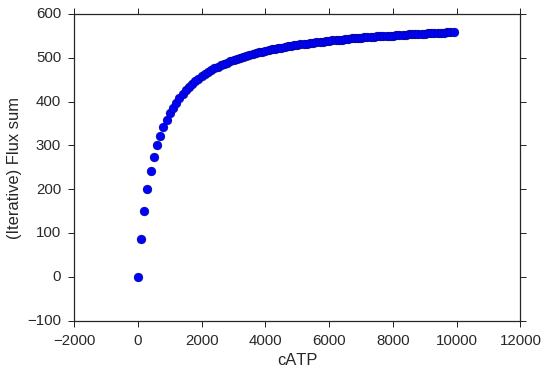

In [136]:
fig = plt.figure()
ax = plt.subplot(111)
clr = sns.color_palette("Blues", 13)

for j in np.arange(1, 10000, 100):
    w = simulation()
    w.cATP = j
    w.simulate()
    
    plt.scatter(j, np.sum(w.flux_u+w.flux_b), s=80)
            
plt.ylabel('(Iterative) Flux sum')
plt.xlabel('cATP')
plt.show()


# Scan over catalytic rate

Maximum eigenvalue = 1.0000000000000018
Eigenvector method: intrasurface flux sum = 0.09171104431152344
Iterative method: Intrasurface flux sum = 0.09171104431152344
Maximum eigenvalue = 1.0000000000000009
Eigenvector method: intrasurface flux sum = 3.712514877319336
Iterative method: Intrasurface flux sum = 3.712514877319336
Maximum eigenvalue = 0.9999999999999964
Eigenvector method: intrasurface flux sum = 6.633481979370117
Iterative method: Intrasurface flux sum = 6.633481979370117
Maximum eigenvalue = 1.0000000000000007
Eigenvector method: intrasurface flux sum = 8.814558029174805
Iterative method: Intrasurface flux sum = 8.814558029174805
Maximum eigenvalue = 1.0000000000000036
Eigenvector method: intrasurface flux sum = 10.953533172607422
Iterative method: Intrasurface flux sum = 10.953533172607422
Maximum eigenvalue = 1.0000000000000016
Eigenvector method: intrasurface flux sum = 12.153945922851562
Iterative method: Intrasurface flux sum = 12.153945922851562
Maximum eigenvalue =

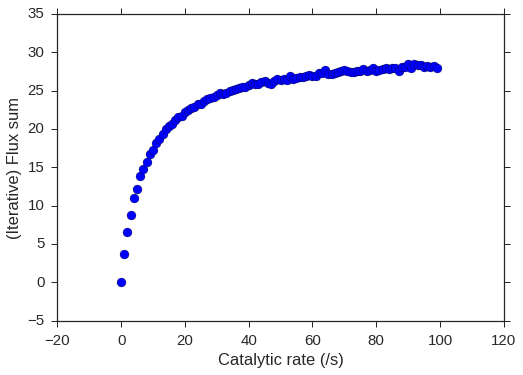

In [137]:
fig = plt.figure()
ax = plt.subplot(111)
clr = sns.color_palette("Blues", 13)

for j in np.arange(0, 100, 1):
    w = simulation()
    w.catalytic_rate = j
    w.simulate()
    
    plt.scatter(j, np.sum(w.flux_u+w.flux_b), s=80)
            
plt.ylabel('(Iterative) Flux sum')
plt.xlabel('Catalytic rate (/s)')
plt.show()


Maximum eigenvalue = 1.0000000000000018
Eigenvector method: intrasurface flux sum = 0.09171104431152344
Iterative method: Intrasurface flux sum = 0.09171104431152344
Maximum eigenvalue = 1.0000000000000009
Eigenvector method: intrasurface flux sum = 3.712514877319336
Iterative method: Intrasurface flux sum = 3.712514877319336
Maximum eigenvalue = 0.9999999999999964
Eigenvector method: intrasurface flux sum = 6.633481979370117
Iterative method: Intrasurface flux sum = 6.633481979370117
Maximum eigenvalue = 1.0000000000000007
Eigenvector method: intrasurface flux sum = 8.814558029174805
Iterative method: Intrasurface flux sum = 8.814558029174805
Maximum eigenvalue = 1.0000000000000036
Eigenvector method: intrasurface flux sum = 10.953533172607422
Iterative method: Intrasurface flux sum = 10.953533172607422
Maximum eigenvalue = 1.0000000000000016
Eigenvector method: intrasurface flux sum = 12.153945922851562
Iterative method: Intrasurface flux sum = 12.153945922851562
Maximum eigenvalue =

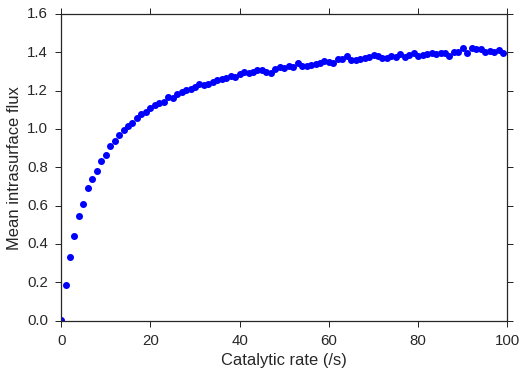

In [138]:
fig = plt.figure()
ax = plt.subplot(111)
clr = sns.color_palette("Blues", 13)

from scipy import stats


for j in np.arange(0, 100, 1):
    w = simulation()
    w.catalytic_rate = j
    w.simulate()
    
    # plt.scatter(j, np.sum(w.flux_u+w.flux_b), s=80)
    ax.errorbar(j, np.mean(w.flux_u+w.flux_b), yerr=stats.sem(w.flux_u+w.flux_b), fmt='-o', c='b')
            
plt.ylabel('Mean intrasurface flux')
plt.xlabel('Catalytic rate (/s)')
plt.show()


## Scan over bins in the energy surface
Is flux sensitive to the number of bins? It shouldn't be.

Maximum eigenvalue = 0.9999999999999999
Eigenvector method: intrasurface flux sum = 0.0
Iterative method: Intrasurface flux sum = 0.0
Maximum eigenvalue = 1.0000000000000007
Eigenvector method: intrasurface flux sum = 2.896839141845703
Iterative method: Intrasurface flux sum = 2.896839141845703
Maximum eigenvalue = 1.000000000000002
Eigenvector method: intrasurface flux sum = 6.130002498626709
Iterative method: Intrasurface flux sum = 6.130002498626709
Maximum eigenvalue = 1.0000000000000016
Eigenvector method: intrasurface flux sum = 9.366122722625732
Iterative method: Intrasurface flux sum = 9.366122722625732
Maximum eigenvalue = 1.000000000000001
Eigenvector method: intrasurface flux sum = 12.541470527648926
Iterative method: Intrasurface flux sum = 12.541470527648926
Maximum eigenvalue = 1.0000000000000007
Eigenvector method: intrasurface flux sum = 15.942450046539307
Iterative method: Intrasurface flux sum = 15.942450046539307
Maximum eigenvalue = 0.9999999999999992
Eigenvector me

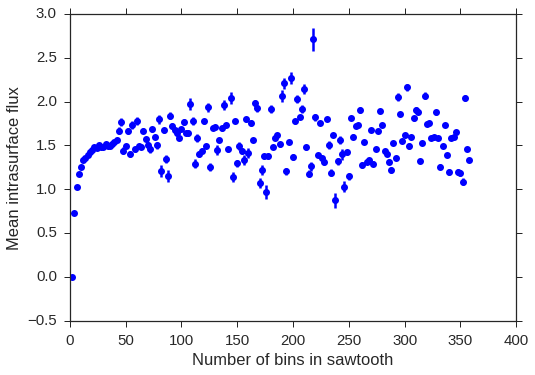

In [155]:
fig = plt.figure()
ax = plt.subplot(111)
clr = sns.color_palette("Blues", 13)

from scipy import stats


for j in np.arange(2, 360, 2):
    w = simulation()
    w.unbound = np.array([saw(i, j) for i in range(j)])
    w.bound = np.array([saw(i + int(j/2.), j) for i in range(j)])
    # We have to override these bin-dependent quantities.
    w.bins = len(w.unbound)
    w.tm = np.zeros((w.bins, w.bins))
    w.iterations=0
    w.C_intrasurface = w.C_intrasurface_0 / (360 / w.bins)    
    w.simulate()
    
    ax.errorbar(j, np.mean(w.flux_u+w.flux_b), yerr=stats.sem(w.flux_u+w.flux_b), fmt='-o', c='b')
            
plt.ylabel('Mean intrasurface flux')
plt.xlabel('Number of bins in sawtooth')
plt.show()


Maximum eigenvalue = 0.9999999999999999
Eigenvector method: intrasurface flux sum = 0.0
Iterative method: Intrasurface flux sum = 0.0
Maximum eigenvalue = 1.0000000000000007
Eigenvector method: intrasurface flux sum = 2.896839141845703
Iterative method: Intrasurface flux sum = 2.896839141845703
Maximum eigenvalue = 1.000000000000002
Eigenvector method: intrasurface flux sum = 6.130002498626709
Iterative method: Intrasurface flux sum = 6.130002498626709
Maximum eigenvalue = 1.0000000000000016
Eigenvector method: intrasurface flux sum = 9.366122722625732
Iterative method: Intrasurface flux sum = 9.366122722625732
Maximum eigenvalue = 1.000000000000001
Eigenvector method: intrasurface flux sum = 12.541470527648926
Iterative method: Intrasurface flux sum = 12.541470527648926
Maximum eigenvalue = 1.0000000000000007
Eigenvector method: intrasurface flux sum = 15.942450046539307
Iterative method: Intrasurface flux sum = 15.942450046539307
Maximum eigenvalue = 0.9999999999999992
Eigenvector me

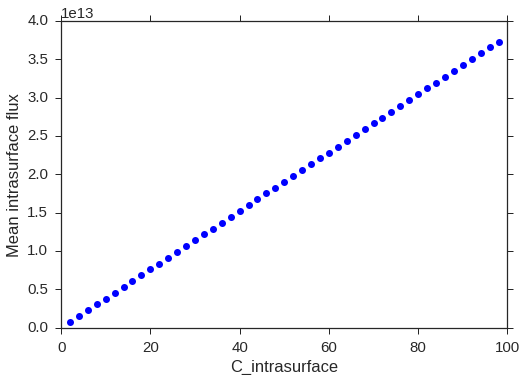

In [156]:
fig = plt.figure()
ax = plt.subplot(111)
clr = sns.color_palette("Blues", 13)

from scipy import stats


for j in np.arange(2, 100, 2):
    w = simulation()
    w.unbound = np.array([saw(i, j) for i in range(j)])
    w.bound = np.array([saw(i + int(j/2.), j) for i in range(j)])
    # We have to override these bin-dependent quantities.
    w.bins = len(w.unbound)
    w.tm = np.zeros((w.bins, w.bins))
    w.iterations=0
    w.C_intrasurface = w.C_intrasurface_0 / (360 / w.bins)    
    w.simulate()
    
    ax.errorbar(j, w.C_intrasurface, yerr=stats.sem(w.flux_u+w.flux_b), fmt='-o', c='b')
            
plt.ylabel('C_intrasurface')
plt.xlabel('Number of bins in sawtooth')
plt.show()


# Now scan over the MD data.

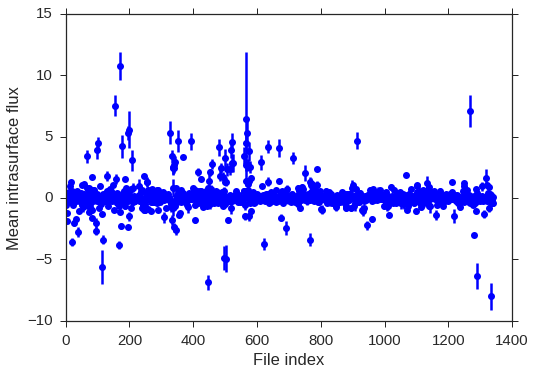

In [254]:
dir              = '/home/dslochower/Dropbox/DavidS/ProteinKinaseATorsions/'
unbound_files    = sorted(glob.glob(dir+'apo/'+'*'))
bound_files      = sorted(glob.glob(dir+'atpmg/'+'*'))
all_fluxes       = []
all_errs         = []
files            = []
fig = plt.figure()
ax = plt.subplot(111)

for i in range(len(unbound_files)):
    name = os.path.splitext(os.path.basename(unbound_files[i]))[0]
    if name == 'chi1CYM185_chi_pop_hist_targ':
        continue
    else:
        unbound = genfromtxt(unbound_files[i], delimiter=',', skip_header=1)
        bound = genfromtxt(bound_files[i], delimiter=',', skip_header=1)
        unbound_name = unbound_files[i].split('/')[-1].split('_')[0]
        bound_name = bound_files[i].split('/')[-1].split('_')[0]
        assert(unbound_name == bound_name)

        this = simulation()
        this.bins = len(unbound)
        this.unbound = this.data_to_energy(unbound)
        this.bound = this.data_to_energy(bound)
        this.tm = np.zeros((this.bins, this.bins))
        this.C_intrasurface = this.C_intrasurface_0 / (360. / this.bins)
        this.simulate()
        all_fluxes.append(np.mean(this.flux_u+this.flux_b))
        all_errs.append(stats.sem(this.flux_u+this.flux_b))
        files.append(unbound_name)
        ax.errorbar(i, np.mean(this.flux_u+this.flux_b), yerr=stats.sem(this.flux_u+this.flux_b), fmt='-o', c='b')
        del this

clr = sns.color_palette("Blues", 13)
# ax.scatter(range(len(unbound_files)), all_fluxes, s=80)
plt.ylabel('Mean intrasurface flux')
plt.xlabel('File index')
plt.show()


/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:152: ComplexWarning: Casting complex values to real discards the imaginary part


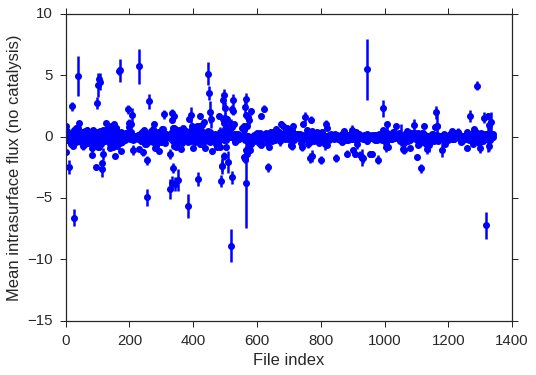

In [265]:
dir              = '/home/dslochower/Dropbox/DavidS/ProteinKinaseATorsions/'
unbound_files    = sorted(glob.glob(dir+'apo/'+'*'))
bound_files      = sorted(glob.glob(dir+'atpmg/'+'*'))
all_fluxes       = []
all_errs         = []
files            = []
fig = plt.figure()
ax = plt.subplot(111)

for i in range(len(unbound_files)):
    name = os.path.splitext(os.path.basename(unbound_files[i]))[0]
    if name == 'chi1CYM185_chi_pop_hist_targ':
        continue
    else:
        unbound = genfromtxt(unbound_files[i], delimiter=',', skip_header=1)
        bound = genfromtxt(bound_files[i], delimiter=',', skip_header=1)
        unbound_name = unbound_files[i].split('/')[-1].split('_')[0]
        bound_name = bound_files[i].split('/')[-1].split('_')[0]
        assert(unbound_name == bound_name)

        this = simulation()
        this.bins = len(unbound)
        this.unbound = this.data_to_energy(unbound)
        this.bound = this.data_to_energy(bound)
        this.tm = np.zeros((this.bins, this.bins))
        this.C_intrasurface = this.C_intrasurface_0 / (360. / this.bins)
        this.catalytic_rate = 0
        this.simulate()
        all_fluxes.append(np.mean(this.flux_u+this.flux_b))
        all_errs.append(stats.sem(this.flux_u+this.flux_b))
        files.append(unbound_name)
        ax.errorbar(i, np.mean(this.flux_u+this.flux_b), yerr=stats.sem(this.flux_u+this.flux_b), fmt='-o', c='b')
        del this

clr = sns.color_palette("Blues", 13)
# ax.scatter(range(len(unbound_files)), all_fluxes, s=80)
plt.ylabel('Mean intrasurface flux (no catalysis)')
plt.xlabel('File index')
plt.show()


In [ ]:
# Sawtooth

dir              = '/home/dslochower/Dropbox/DavidS/ProteinKinaseATorsions/'
unbound_files    = sorted(glob.glob(dir+'apo/'+'*'))
bound_files      = sorted(glob.glob(dir+'atpmg/'+'*'))
all_fluxes       = []
all_errs         = []
files            = []
fig = plt.figure()
ax = plt.subplot(111)

for i in range(len(unbound_files)):
    name = os.path.splitext(os.path.basename(unbound_files[i]))[0]
    if name == 'chi1CYM185_chi_pop_hist_targ':
        continue
    else:
        unbound = genfromtxt(unbound_files[i], delimiter=',', skip_header=1)
        bound = genfromtxt(bound_files[i], delimiter=',', skip_header=1)
        unbound_name = unbound_files[i].split('/')[-1].split('_')[0]
        bound_name = bound_files[i].split('/')[-1].split('_')[0]
        assert(unbound_name == bound_name)

        this = simulation()
        this.bins = len(unbound)
        this.unbound = this.data_to_energy(unbound)
        this.bound = this.data_to_energy(bound)
        this.tm = np.zeros((this.bins, this.bins))
        this.C_intrasurface = this.C_intrasurface_0 / (360. / this.bins)
        this.catalytic_rate = 0
        this.simulate()
        all_fluxes.append(np.mean(this.flux_u+this.flux_b))
        all_errs.append(stats.sem(this.flux_u+this.flux_b))
        files.append(unbound_name)
        ax.errorbar(i, np.mean(this.flux_u+this.flux_b), yerr=stats.sem(this.flux_u+this.flux_b), fmt='-o', c='b')
        del this

clr = sns.color_palette("Blues", 13)
# ax.scatter(range(len(unbound_files)), all_fluxes, s=80)
plt.ylabel('Mean intrasurface flux (no catalysis)')
plt.xlabel('File index')
plt.show()

In [249]:
import pandas as pd
df = pd.DataFrame()
df['Name'] = files
df['Flux'] = all_fluxes
df['SEMs'] = all_errs

In [250]:
df[df['Flux']>0.5]

,Name,Flux,SEMs
13,chi1ARG42,0.960608,0.016362
17,chi1ASN202,1.322474,0.132076
21,chi1ASN272,0.554918,0.074774
35,chi1ASP206,0.557741,0.055957
49,chi1CYS329,1.099625,0.091813
55,chi1GLN228,1.124579,0.142587
65,chi1GLU10,3.390852,0.504829
66,chi1GLU113,0.779678,0.005062
72,chi1GLU194,0.817565,0.115459
73,chi1GLU216,0.547914,0.074043


Let's just select \#193. It has reasonable positive flux and a small SEM.

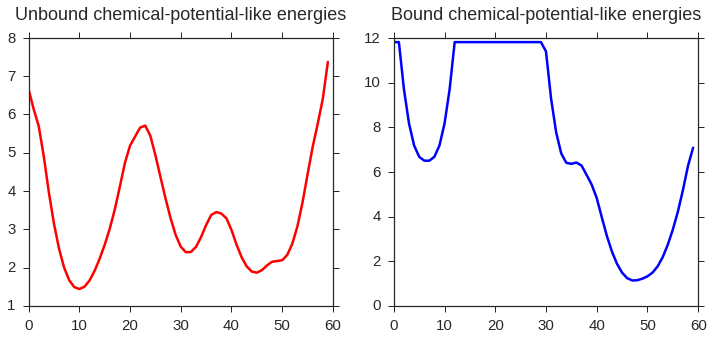

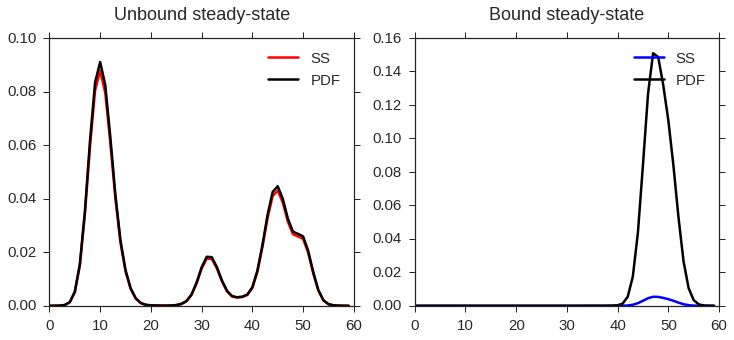

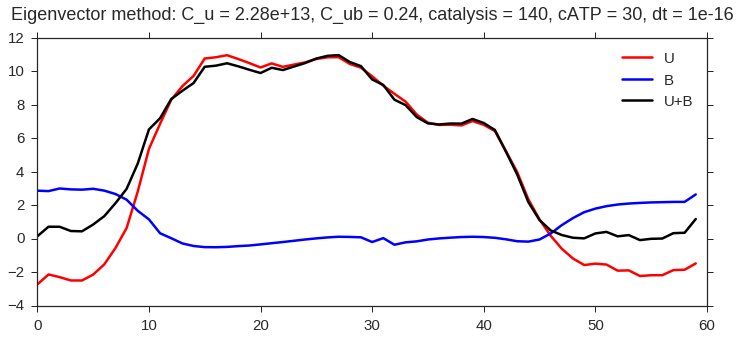

Running iterative method with 0 iterations


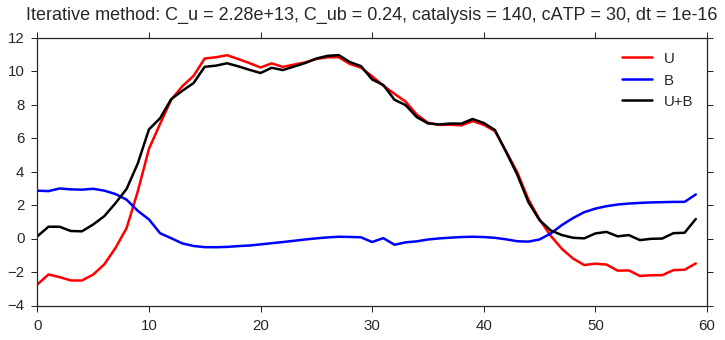

5.285486852245859 +/- 0.5465813310552472


In [331]:
dir              = '/home/dslochower/Dropbox/DavidS/ProteinKinaseATorsions/'
unbound_files    = sorted(glob.glob(dir+'apo/'+'*'))
bound_files      = sorted(glob.glob(dir+'atpmg/'+'*'))

name = 'chi1PHE171'
unbound_files = dir+'apo/'+name+'_chi_pop_hist_targ.txt'
bound_files = dir+'atpmg/'+name+'_chi_pop_hist_ref.txt'
unbound = genfromtxt(unbound_files, delimiter=',', skip_header=1)
bound = genfromtxt(bound_files, delimiter=',', skip_header=1)

this = simulation()
this.bins = len(unbound)
this.unbound = this.data_to_energy(unbound)
this.bound = this.data_to_energy(bound)
this.tm = np.zeros((this.bins, this.bins))
this.C_intrasurface = this.C_intrasurface_0 / (360. / this.bins)
this.iterations = 0

this.simulate(plot=True)

#this.plot_energy()
#this.plot_ss()
#this.plot_flux()
print('{} +/- {}'.format(np.mean(this.flux_u+this.flux_b), stats.sem(this.flux_u+this.flux_b)))


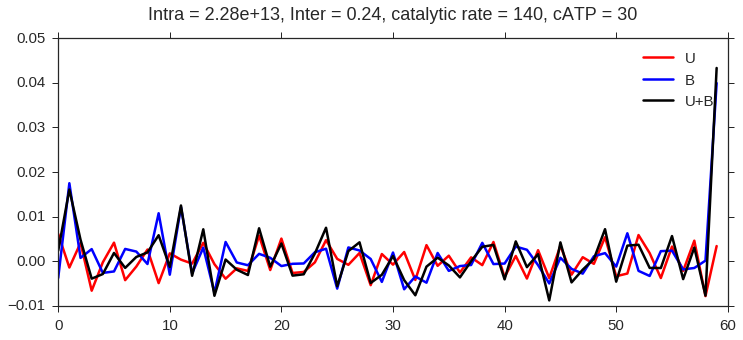

In [332]:
bicg_ss = bicg(this.tm-1, np.zeros((2*this.bins)), x0=this.ss, tol=1e-20)

this.calculate_flux(bicg_ss[0], this.tm)
this.plot_flux()

Okay, turning off catalysis as a reality check.

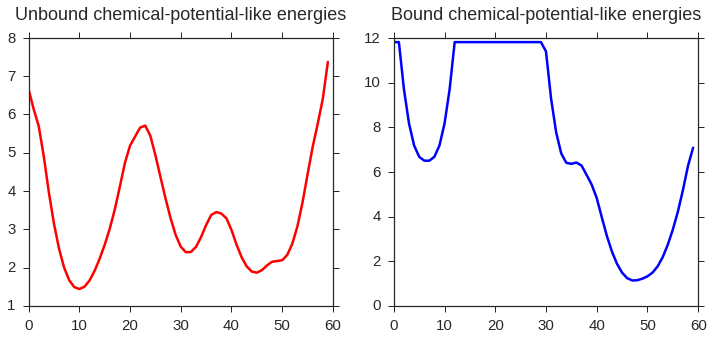

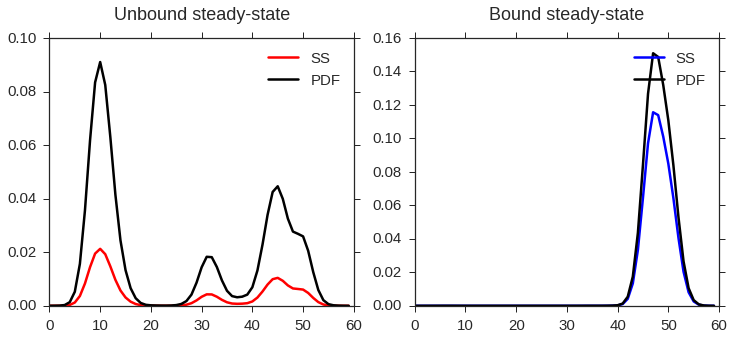

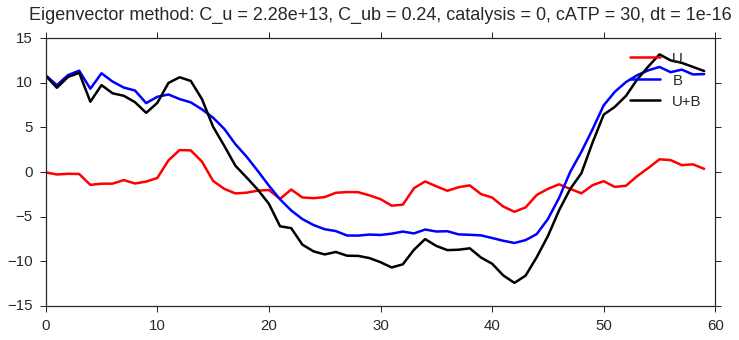

Running iterative method with 10000000 iterations


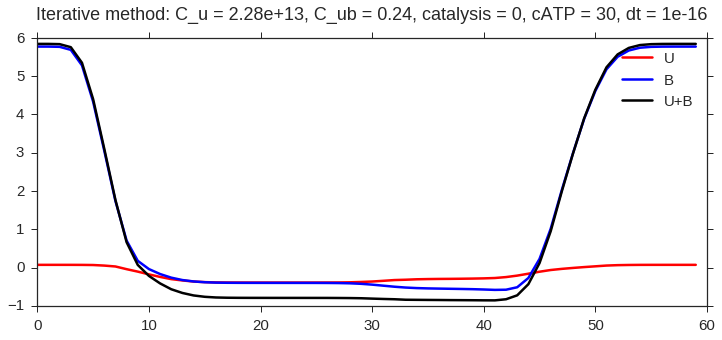

1.3036979443360905 +/- 0.36129125541116364


In [294]:
dir              = '/home/dslochower/Dropbox/DavidS/ProteinKinaseATorsions/'
unbound_files    = sorted(glob.glob(dir+'apo/'+'*'))
bound_files      = sorted(glob.glob(dir+'atpmg/'+'*'))

name = 'chi1PHE171'
unbound_files = dir+'apo/'+name+'_chi_pop_hist_targ.txt'
bound_files = dir+'atpmg/'+name+'_chi_pop_hist_ref.txt'
unbound = genfromtxt(unbound_files, delimiter=',', skip_header=1)
bound = genfromtxt(bound_files, delimiter=',', skip_header=1)

this = simulation()
this.bins = len(unbound)
this.unbound = this.data_to_energy(unbound)
this.bound = this.data_to_energy(bound)
this.tm = np.zeros((this.bins, this.bins))
this.C_intrasurface = this.C_intrasurface_0 / (360. / this.bins)

this.catalytic_rate = 0
this.iterations = 10000000

this.simulate(plot=True)

#this.plot_energy()
#this.plot_ss()
#this.plot_flux()
print('{} +/- {}'.format(np.mean(this.flux_u+this.flux_b), stats.sem(this.flux_u+this.flux_b)))
del this

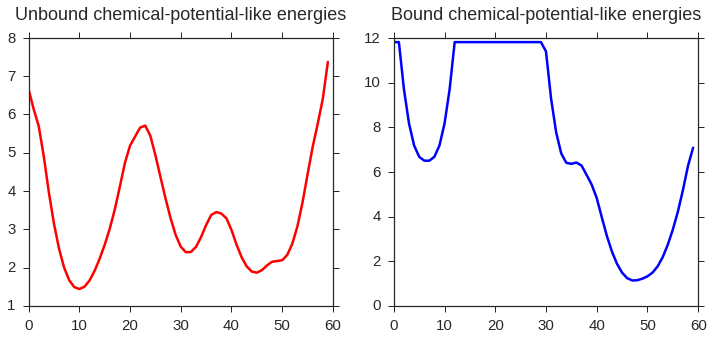

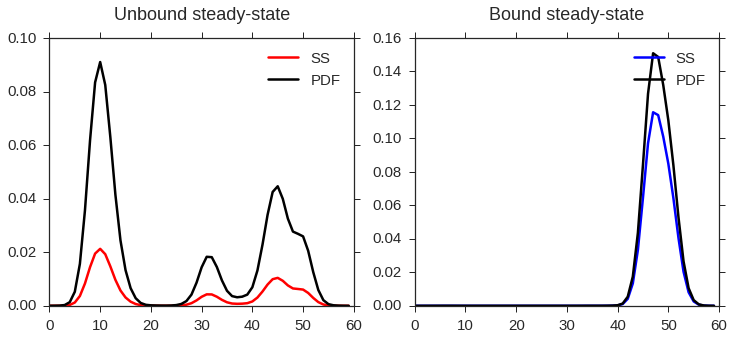

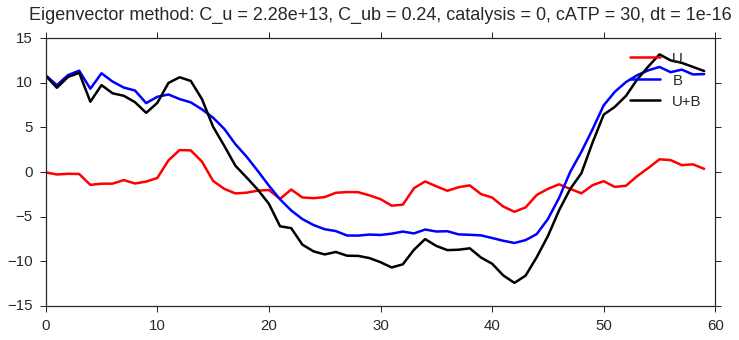

Running iterative method with 0 iterations


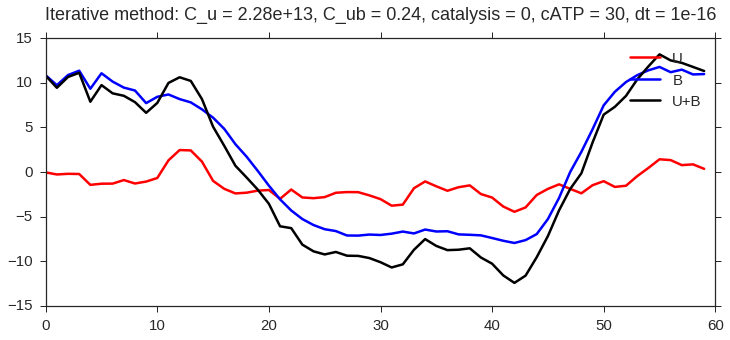

0.20613902666967382 +/- 1.153213465072901


In [315]:
from scipy.sparse.linalg import bicg
dir              = '/home/dslochower/Dropbox/DavidS/ProteinKinaseATorsions/'
unbound_files    = sorted(glob.glob(dir+'apo/'+'*'))
bound_files      = sorted(glob.glob(dir+'atpmg/'+'*'))

name = 'chi1PHE171'
unbound_files = dir+'apo/'+name+'_chi_pop_hist_targ.txt'
bound_files = dir+'atpmg/'+name+'_chi_pop_hist_ref.txt'
unbound = genfromtxt(unbound_files, delimiter=',', skip_header=1)
bound = genfromtxt(bound_files, delimiter=',', skip_header=1)

this = simulation()
this.bins = len(unbound)
this.unbound = this.data_to_energy(unbound)
this.bound = this.data_to_energy(bound)
this.tm = np.zeros((this.bins, this.bins))
this.C_intrasurface = this.C_intrasurface_0 / (360. / this.bins)

this.catalytic_rate = 0
this.iterations = 0

this.simulate(plot=True)

#this.plot_energy()
#this.plot_ss()
#this.plot_flux()
print('{} +/- {}'.format(np.mean(this.flux_u+this.flux_b), stats.sem(this.flux_u+this.flux_b)))

In [316]:
bicg_ss = bicg(this.tm-1, np.zeros((2*this.bins)), x0=this.ss)

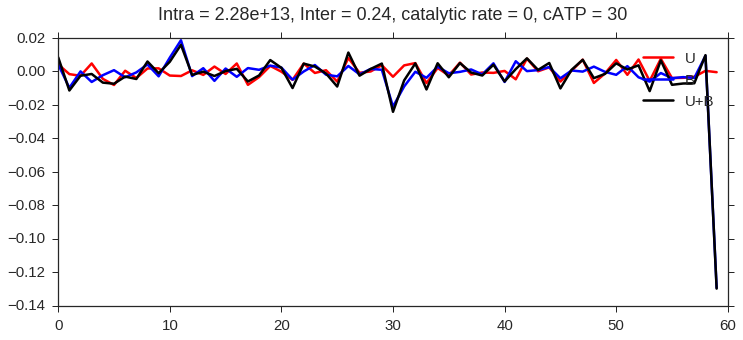

In [328]:
bicg_ss = bicg(this.tm-1, np.zeros((2*this.bins)), x0=this.ss, tol=1e-20)

this.calculate_flux(bicg_ss[0], this.tm)
this.plot_flux()

## Calculate the JSD of the MD data, as a test.

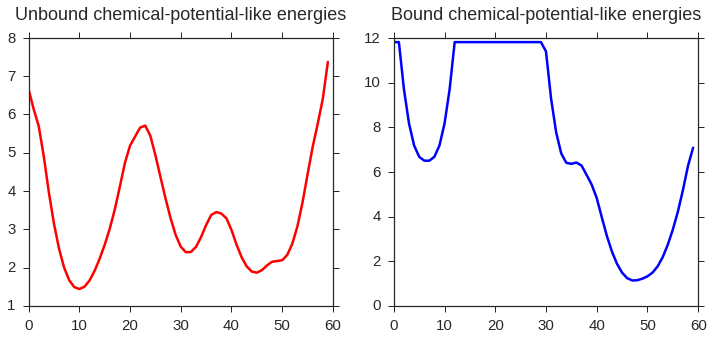

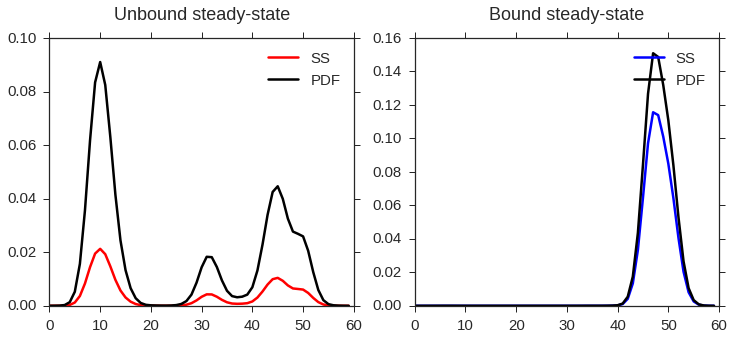

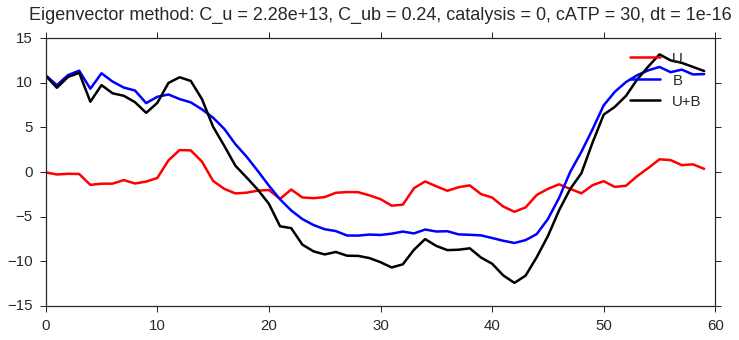

Running iterative method with 0 iterations


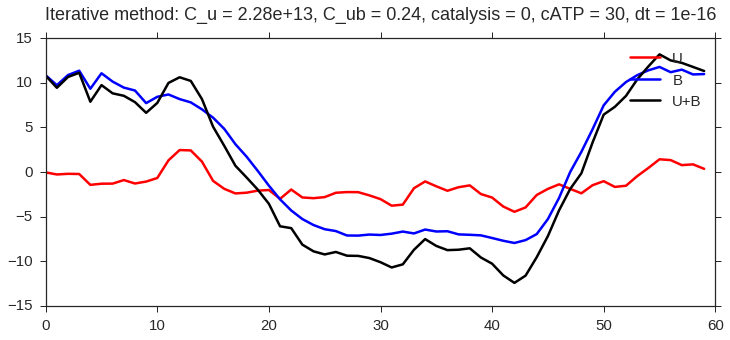

NameError: name 'stats' is not defined

In [16]:
from scipy.sparse.linalg import bicg
dir              = '/home/dslochower/Dropbox/DavidS/ProteinKinaseATorsions/'
unbound_files    = sorted(glob.glob(dir+'apo/'+'*'))
bound_files      = sorted(glob.glob(dir+'atpmg/'+'*'))

name = 'chi1PHE171'
unbound_files = dir+'apo/'+name+'_chi_pop_hist_targ.txt'
bound_files = dir+'atpmg/'+name+'_chi_pop_hist_ref.txt'
unbound = genfromtxt(unbound_files, delimiter=',', skip_header=1)
bound = genfromtxt(bound_files, delimiter=',', skip_header=1)

this = simulation()
this.bins = len(unbound)
this.unbound = this.data_to_energy(unbound)
this.bound = this.data_to_energy(bound)
stuff3 = this.JSD_3(unbound, bound)
this.tm = np.zeros((this.bins, this.bins))
this.C_intrasurface = this.C_intrasurface_0 / (360. / this.bins)

this.catalytic_rate = 0
this.iterations = 0
stuff = this.JSD()
stuff2 = this.JSD_2()

this.simulate(plot=True)
print('{} +/- {}'.format(np.mean(this.flux_u+this.flux_b), stats.sem(this.flux_u+this.flux_b)))

In [17]:
stuff

0.041693357640573914

In [18]:
stuff2

49.11787113608986

In [19]:
stuff3

0.51463706175465429

In [22]:
-

Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running iterative method with 0 iterations
Running ite

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:152: ComplexWarning: Casting complex values to real discards the imaginary part


In [23]:
df

,Name,Flux,SEMs,JSDs
0,chi1ARG119,-0.522430,0.060541,0.011806
1,chi1ARG120,-0.230826,0.069536,0.046672
2,chi1ARG123,0.320799,0.040402,0.027365
3,chi1ARG130,0.062716,0.032887,0.005905
4,chi1ARG151,-0.449300,0.033816,0.167753
5,chi1ARG176,-0.052226,0.022964,0.022304
6,chi1ARG180,0.313883,0.033177,0.043847
7,chi1ARG242,-0.047583,0.021688,0.012198
8,chi1ARG256,-0.265768,0.034096,0.018063
9,chi1ARG266,-0.592546,0.089952,0.088928


In [24]:
df.sort_values("JSDs")

,Name,Flux,SEMs,JSDs
927,phiPRO223,-0.176682,0.072812,0.000354
1177,psiLEU254,0.005359,0.030808,0.000355
506,chi2PHE94,0.099144,0.049194,0.000396
1111,psiGLU93,-1.103114,0.418570,0.000408
729,phiASP287,0.069798,0.056059,0.000445
1015,psiALA24,-0.116564,0.053997,0.000512
841,phiLEU254,0.064778,0.036633,0.000532
517,chi2TYR142,-0.118740,0.031640,0.000547
698,phiARG31,-0.240924,0.049415,0.000553
745,phiGLN25,0.194448,0.049886,0.000560


Okay, chi2ASN157 looks like it will have very different surfaces. Let's check.

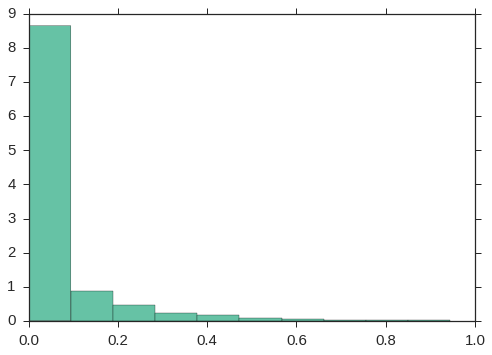

In [29]:
plt.figure()
plt.hist(df['JSDs'], normed=True)
plt.show()

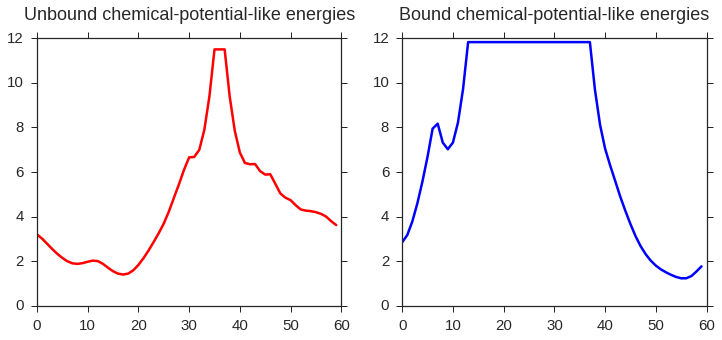

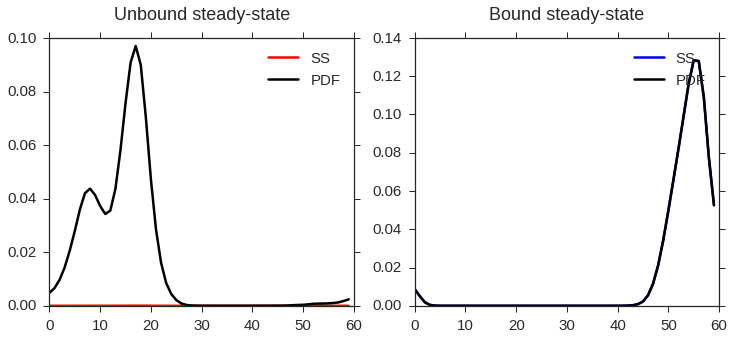

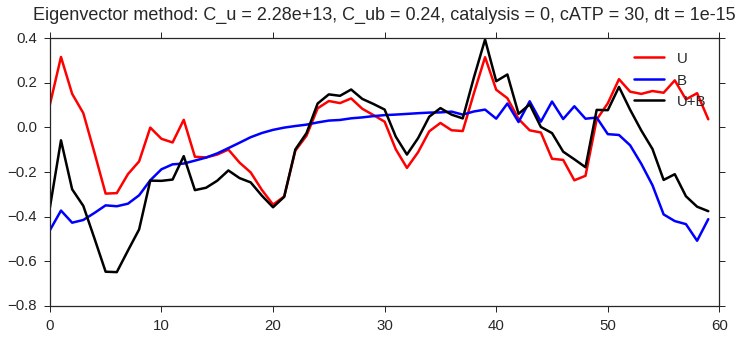

Running iterative method with 0 iterations


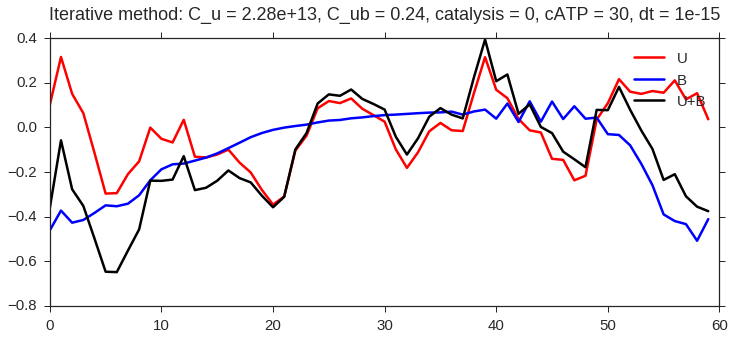

-0.11328104592739467 +/- 0.029600834004101597


In [25]:
from scipy.sparse.linalg import bicg
dir              = '/home/dslochower/Dropbox/DavidS/ProteinKinaseATorsions/'
unbound_files    = sorted(glob.glob(dir+'apo/'+'*'))
bound_files      = sorted(glob.glob(dir+'atpmg/'+'*'))

name = 'chi2ASN157'
unbound_files = dir+'apo/'+name+'_chi_pop_hist_targ.txt'
bound_files = dir+'atpmg/'+name+'_chi_pop_hist_ref.txt'
unbound = genfromtxt(unbound_files, delimiter=',', skip_header=1)
bound = genfromtxt(bound_files, delimiter=',', skip_header=1)

this = simulation()
this.bins = len(unbound)
this.unbound = this.data_to_energy(unbound)
this.bound = this.data_to_energy(bound)
stuff3 = this.JSD_3(unbound, bound)
this.tm = np.zeros((this.bins, this.bins))
this.C_intrasurface = this.C_intrasurface_0 / (360. / this.bins)

this.catalytic_rate = 0
this.iterations = 0
stuff = this.JSD()
stuff2 = this.JSD_2()

this.simulate(plot=True)
print('{} +/- {}'.format(np.mean(this.flux_u+this.flux_b), stats.sem(this.flux_u+this.flux_b)))

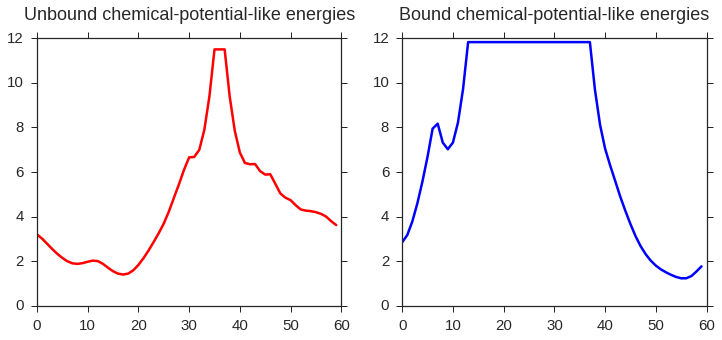

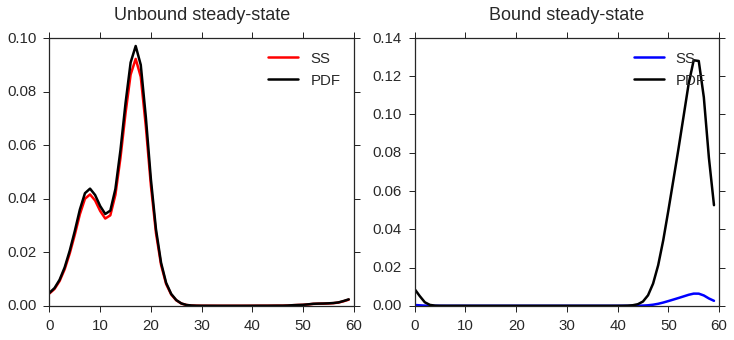

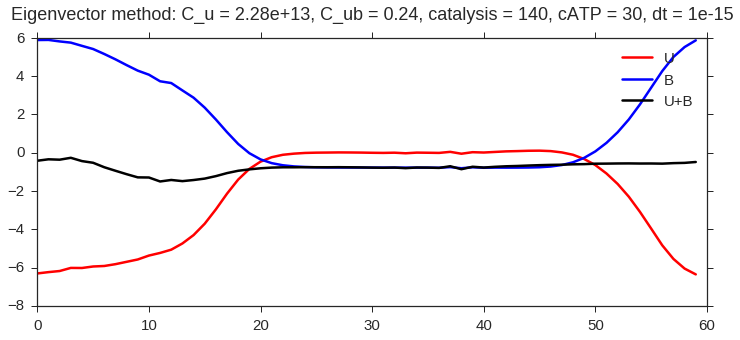

Running iterative method with 0 iterations


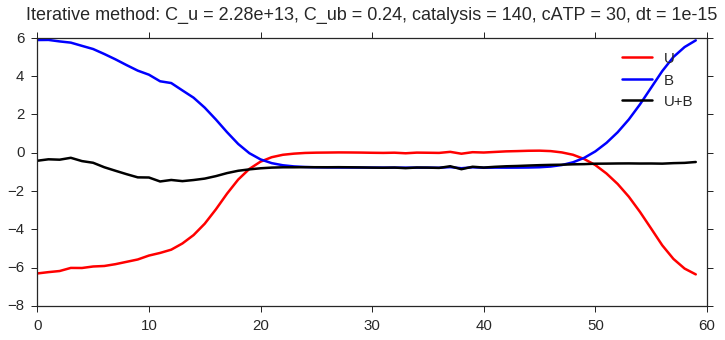

-0.7776044371410459 +/- 0.03681344969848797


In [7]:
from scipy.sparse.linalg import bicg
dir              = '/home/dslochower/Dropbox/Shared with Mike/ProteinKinaseATorsions/'
unbound_files    = sorted(glob.glob(dir+'apo/'+'*'))
bound_files      = sorted(glob.glob(dir+'atpmg/'+'*'))

name = 'chi2ASN157'
unbound_files = dir+'apo/'+name+'_chi_pop_hist_targ.txt'
bound_files = dir+'atpmg/'+name+'_chi_pop_hist_ref.txt'
unbound = genfromtxt(unbound_files, delimiter=',', skip_header=1)
bound = genfromtxt(bound_files, delimiter=',', skip_header=1)

this = simulation()
this.bins = len(unbound)
this.unbound = this.data_to_energy(unbound)
this.bound = this.data_to_energy(bound)
stuff3 = this.JSD_3(unbound, bound)
this.tm = np.zeros((this.bins, this.bins))
this.C_intrasurface = this.C_intrasurface_0 / (360. / this.bins)

this.iterations = 0
stuff = this.JSD()
stuff2 = this.JSD_2()

this.simulate(plot=True)
print('{} +/- {}'.format(np.mean(this.flux_u+this.flux_b), stats.sem(this.flux_u+this.flux_b)))

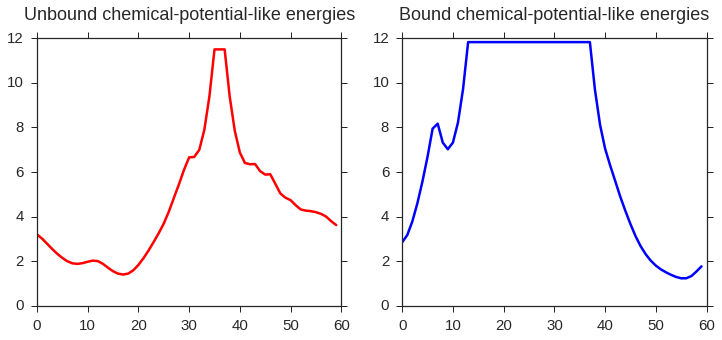

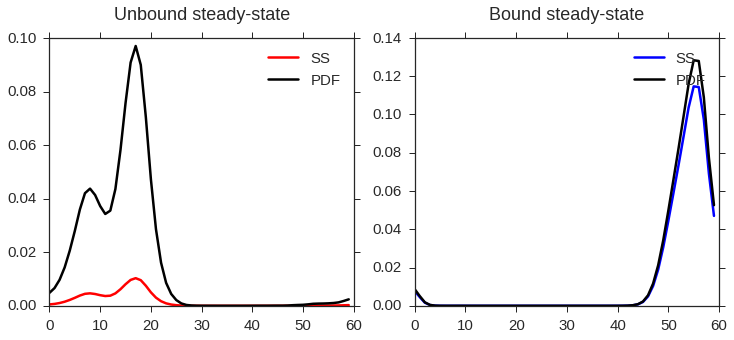

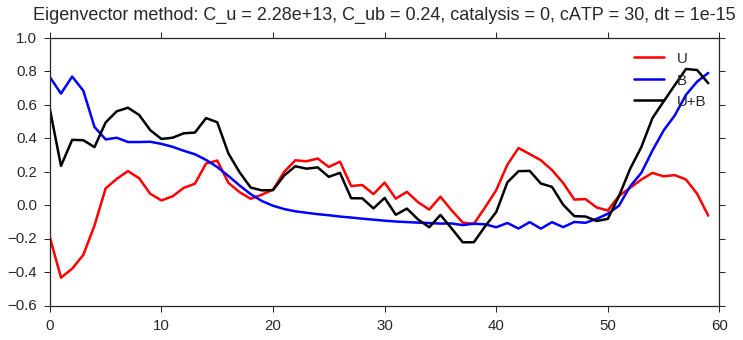

Running iterative method with 1000 iterations


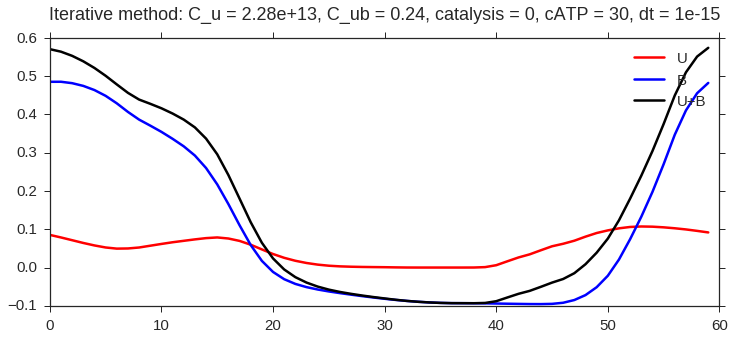

0.15882864850345868 +/- 0.03176526396299062


In [9]:
from scipy.sparse.linalg import bicg
dir              = '/home/dslochower/Dropbox/Shared with Mike/ProteinKinaseATorsions/'
unbound_files    = sorted(glob.glob(dir+'apo/'+'*'))
bound_files      = sorted(glob.glob(dir+'atpmg/'+'*'))

name = 'chi2ASN157'
unbound_files = dir+'apo/'+name+'_chi_pop_hist_targ.txt'
bound_files = dir+'atpmg/'+name+'_chi_pop_hist_ref.txt'
unbound = genfromtxt(unbound_files, delimiter=',', skip_header=1)
bound = genfromtxt(bound_files, delimiter=',', skip_header=1)

this = simulation()
this.bins = len(unbound)
this.catalytic_rate = 0
this.unbound = this.data_to_energy(unbound)
this.bound = this.data_to_energy(bound)
stuff3 = this.JSD_3(unbound, bound)
this.tm = np.zeros((this.bins, this.bins))
this.C_intrasurface = this.C_intrasurface_0 / (360. / this.bins)

this.iterations = 1000
stuff = this.JSD()
stuff2 = this.JSD_2()

this.simulate(plot=True)
print('{} +/- {}'.format(np.mean(this.flux_u+this.flux_b), stats.sem(this.flux_u+this.flux_b)))

Let's go back to the example of the variable amplitude sawtooth that looks bad with no catalysis

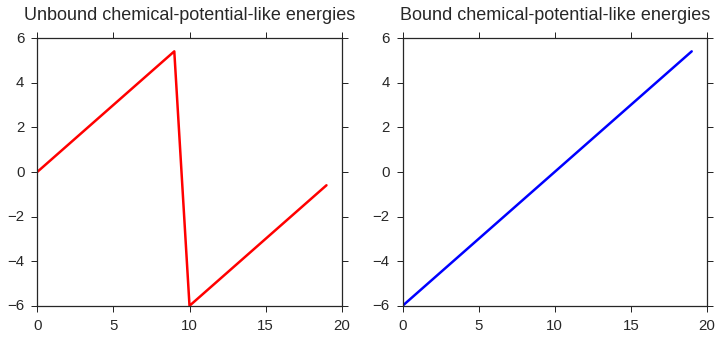

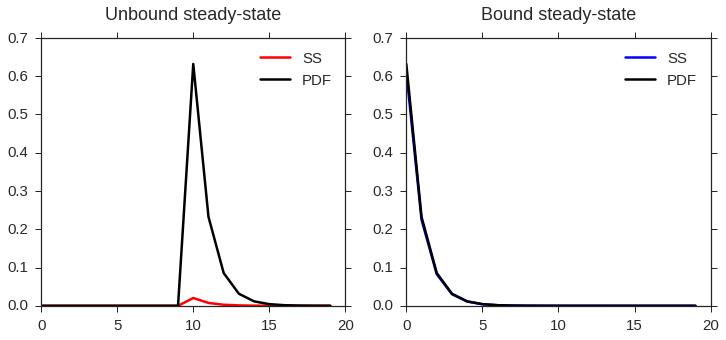

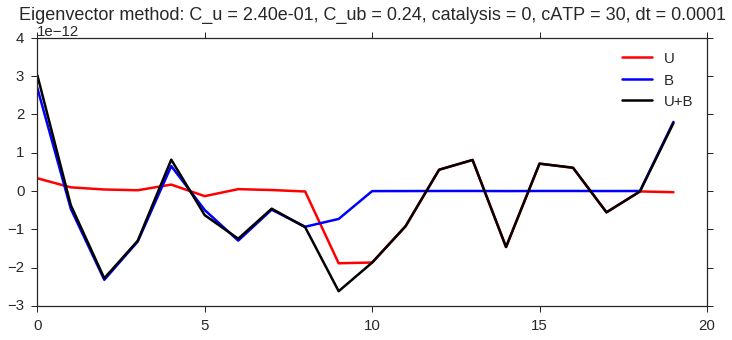

Running iterative method with 1000000 iterations


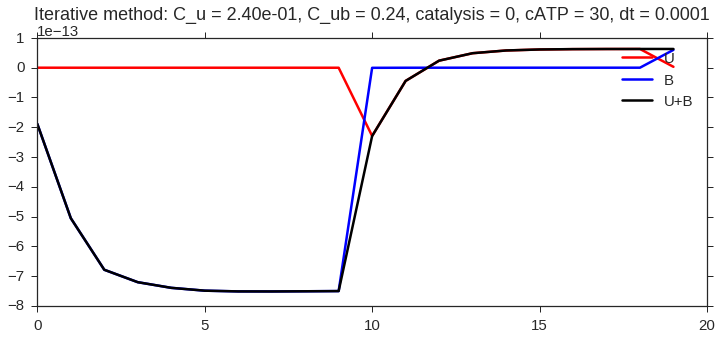

In [16]:
example = simulation()
example.catalytic_rate = 0
example.unbound = np.array([variable_saw(12, i, 20) for i in range(20)])
example.bound = np.array([variable_saw(12, i + 10, 20) for i in range(20)])
example.C_intrasurface = 0.24
example.C_APT = 2000
example.iterations = 1000000
example.simulate(plot=True)

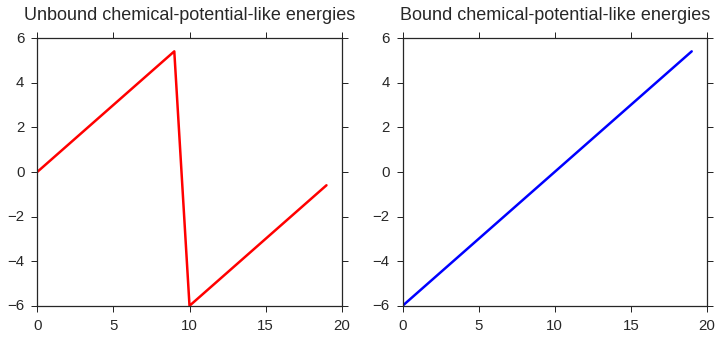

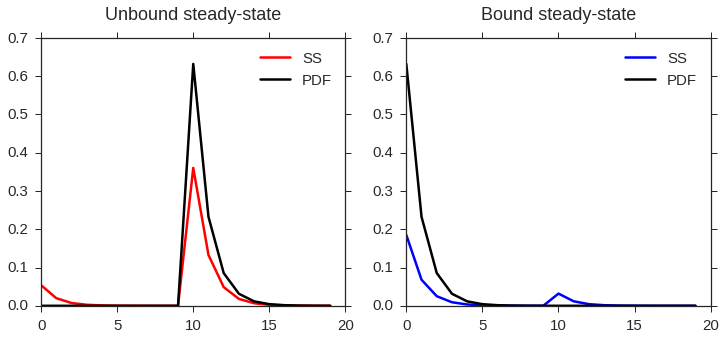

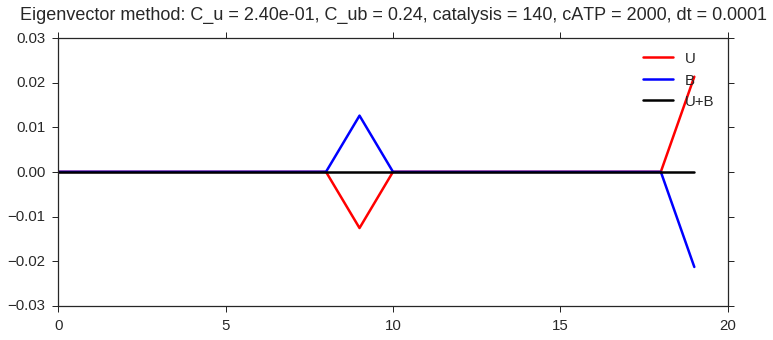

Running iterative method with 1000000 iterations


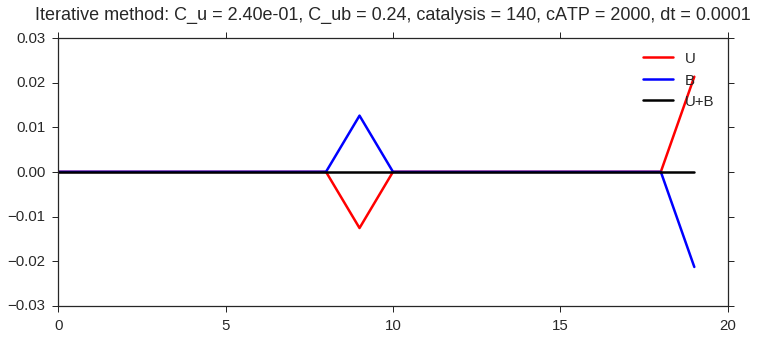

In [17]:
example = simulation()
example.unbound = np.array([variable_saw(12, i, 20) for i in range(20)])
example.bound = np.array([variable_saw(12, i + 10, 20) for i in range(20)])
example.C_intrasurface = 0.24
example.cATP = 2000
example.iterations = 1000000
example.simulate(plot=True)

In [18]:
example.flux_b+example.flux_u

array([  1.94450425e-05,   1.94450420e-05,   1.94450419e-05,
         1.94450418e-05,   1.94450418e-05,   1.94450418e-05,
         1.94450418e-05,   1.94450418e-05,   1.94450418e-05,
         1.94450418e-05,   1.94450430e-05,   1.94450434e-05,
         1.94450436e-05,   1.94450436e-05,   1.94450437e-05,
         1.94450437e-05,   1.94450437e-05,   1.94450437e-05,
         1.94450437e-05,   1.94450437e-05])

In [56]:
np.dot(example.ss, example.tm) - example.ss

array([  2.18660708e-16,  -1.28197590e-16,  -9.35462128e-17,
        -3.27368176e-17,  -7.29361277e-17,  -3.31127083e-17,
         6.65953615e-17,  -3.30405467e-17,  -2.82722868e-17,
         1.18258374e-16,  -2.49800181e-16,   3.74700271e-16,
         3.46944695e-18,   1.73472348e-17,   5.94142791e-17,
         2.51751744e-16,  -4.30970364e-17,  -1.14383329e-16,
        -3.37505360e-16,   3.26717548e-17,  -2.77555756e-16,
         3.60822483e-16,  -2.35922393e-16,  -7.97972799e-17,
        -8.84708973e-17,   1.83880688e-16,  -8.82540568e-17,
         6.27753058e-17,  -2.94360890e-17,   1.61681649e-17,
        -8.67700551e-18,   8.47371760e-18,  -5.44599833e-18,
         2.72405796e-18,  -9.37400775e-19,   6.95705217e-19,
        -3.00392294e-19,   4.79797843e-20,  -6.77345116e-20,
         1.59116567e-16])

In [57]:
# Total difference after 1 iteration
np.sum(abs(np.dot(example.ss, example.tm) - example.ss))

3.9190670432411594e-15

In [58]:
# Difference after 2 iterations
new = np.dot(example.ss, example.tm)
np.sum(abs(np.dot(new, example.tm) - new))

3.8075730104286527e-15

In [60]:
# Difference after 3 iterations
new = np.dot(example.ss, example.tm)
newnew = np.dot(new, example.tm)
np.sum(abs(np.dot(newnew, example.tm) - newnew))

3.7822133959241227e-15

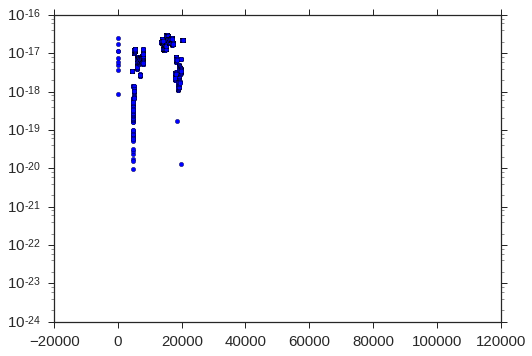

In [88]:
tmp =[]
population = np.copy(example.ss)
for _i in range(100000):
    diff = np.sum(abs(np.dot(population, example.tm)) - population)
    plt.scatter(_i, diff)
    tmp.append(diff)
    new_population = np.dot(population, example.tm)
    population = list(new_population) # Copy contents only.
plt.ylim([10**-24, 10**-16])
plt.yscale('log')
plt.show()

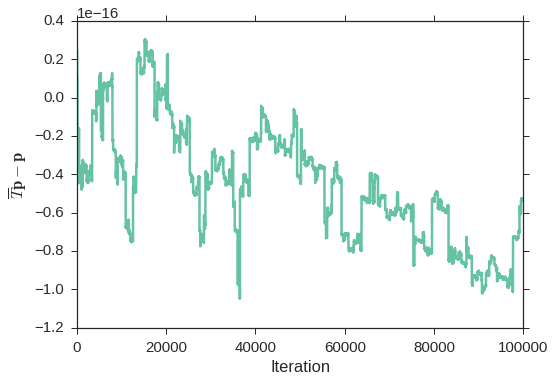

In [89]:
plt.figure()
plt.plot(tmp)
plt.ylabel('$\\overline{T} \\mathbf{p} - \\mathbf{p}$')
plt.xlabel('Iteration')

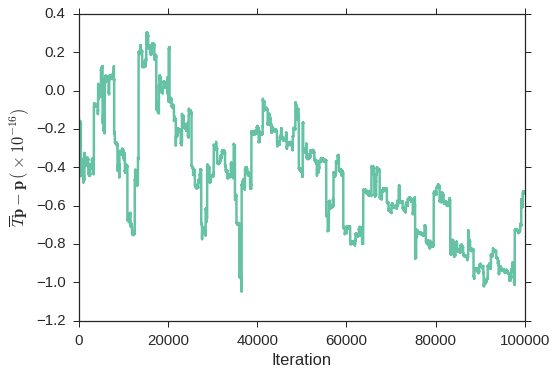

In [96]:
plt.figure()
plt.plot([i*10**16 for i in tmp])
plt.ylabel('$\\overline{T} \\mathbf{p} - \\mathbf{p} \\,( \\times 10^{-16})$')
plt.xlabel('Iteration')

In [74]:
new_population - population

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

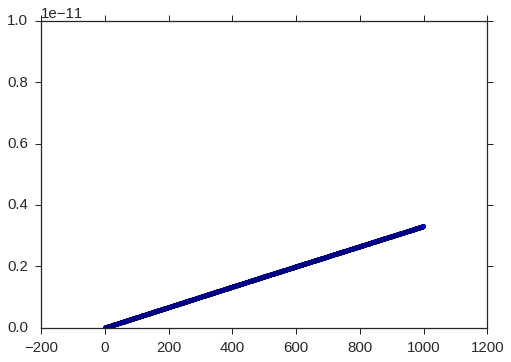

In [55]:
# diff = np.dot(example.ss, example.tm) - example.ss
new_population = np.copy(example.ss)
plt.figure()
for _i in range(1000):
    new_population = np.dot(new_population, example.tm)
    diff = np.sum(abs(new_population - example.ss))
    plt.scatter(_i, diff)
plt.ylim([10**-15, 10**-11])
plt.show()

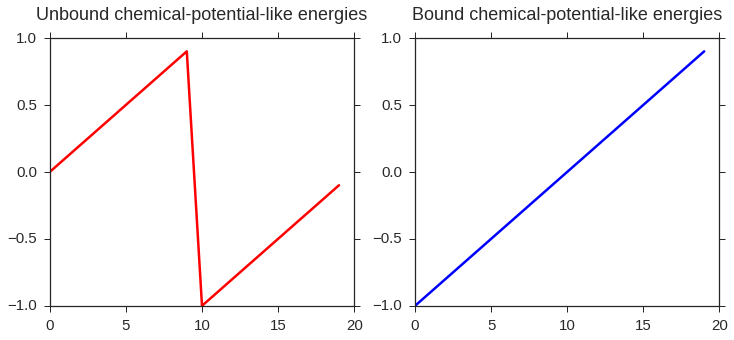

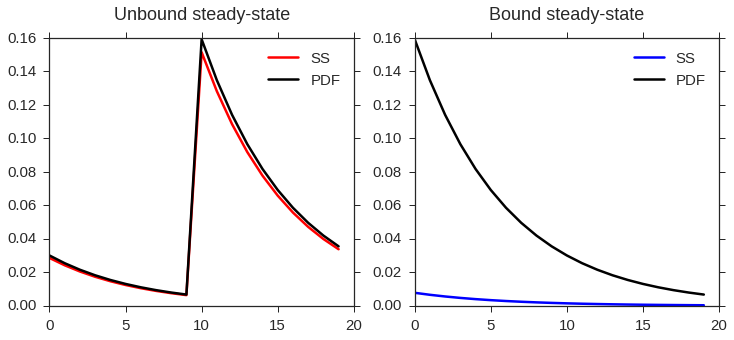

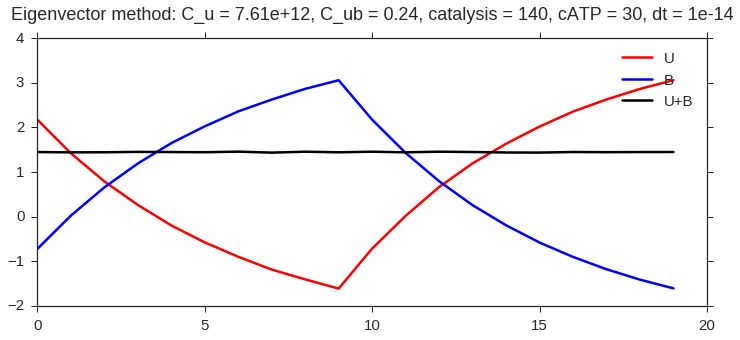

Running iterative method with 0 iterations


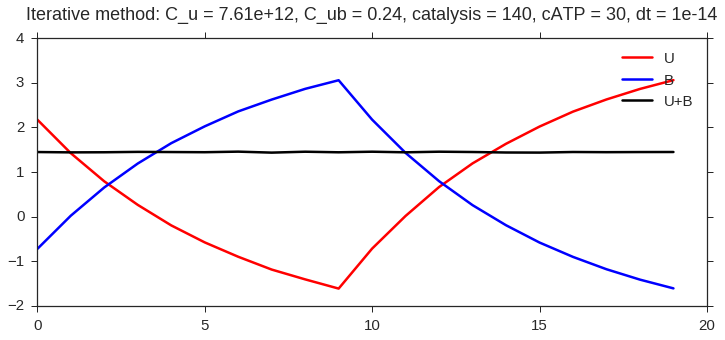

In [5]:
example = simulation()
example.simulate(plot=True)